# CRNN 20x under-sampling

# This was done in  Google cloud, using V100 GPUs

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data preparation

Note that I had to deal with several data coming from different places in different formats. I used Jupyter notebook to prepare the data and then run the network also using the jupyter notebook.

In [2]:
#Used to prepare the data in the the appropriate tensor format
def complex_to_real(x, axis=1):
    """
    Converts complex data to a data with 2 channels with real data
    x: input
    axis: representst the real and complex channel.
    """
    shape = x.shape
    if x.dtype == np.complex64:
        dtype = np.float32
    else:
        dtype = np.float64
    
    x = np.ascontiguousarray(x).view(dtype=dtype).reshape(shape+(2,))
    n = x.ndim
    if axis < 0:
        axis = n + axis
    if axis < n:
        x = x.transpose(tuple([i for i in range(0, axis)]) + (n-1,) \
                   + tuple([i for i in range(axis, n-1)]))
    return x


def to_tensor_format(x, fake_imaginary=False):
    """"
    Takes the data as of shape (N [,T], x, y), T is the sequence times
    reshapse to (n, N_channels, x, t, T)
    """
    if x.ndim == 4:
        x = np.transpose(x, (0,2,3,1))

    if fake_imaginary:
        # Add zero as the imaginary parts
        x = x*(1+0j)

    x = complex_to_real(x)
    return x

In [3]:
# Reading the training data
data_recon_1 = scipy.io.loadmat('data/resampledData_Training_20under_1to500.mat')
data_recon_2 = scipy.io.loadmat('data/resampledData_Training_20under_501to1200.mat')

data_truth_1 = data_recon_1['imagesTruth']
data_truth_2 = data_recon_2['imagesTruth']

data_resampled_1 = data_recon_1['imagesResampled']
data_resampled_2 = data_recon_2['imagesResampled']

data_truth = np.ndarray((128, 128, 20, 1200))
for k in range(500):
    data_truth[:,:,:,k] = data_truth_1[:,:,:,k]
for k in range(700):
    data_truth[:,:,:,k+500] = data_truth_2[:,:,:,k+500]
    
data_recon = np.ndarray((128, 128, 20, 1200))
for k in range(500):
    data_recon[:,:,:,k] = data_resampled_1[:,:,:,k]
for k in range(700):
    data_recon[:,:,:,k+500] = data_resampled_2[:,:,:,k+500]
    
del data_recon_1, data_recon_2, data_truth_1, data_truth_2, data_resampled_1, data_resampled_2

In [4]:
data_recon = data_recon.transpose()
data_truth = data_truth.transpose()
print(data_recon.shape)
print(data_truth.shape)

(1200, 20, 128, 128)
(1200, 20, 128, 128)


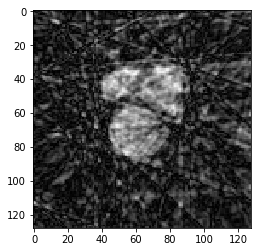

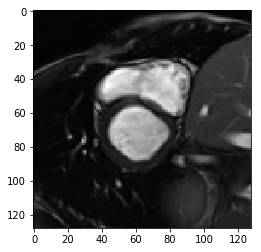

In [5]:
plt.imshow(data_recon[0,0,:,:], cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:], cmap='gray')
plt.show()

In [6]:
# Reading training k-space data
data_k1 = scipy.io.loadmat('data/Training_20und_K1.mat')
data_k2 = scipy.io.loadmat('data/Training_20und_K2.mat')

In [7]:
data_k1 = data_k1['k_data_1']
data_k2 = data_k2['k_data_2']

In [8]:
data_k2.shape

(128, 128, 20, 601)

In [9]:
data_k = np.ndarray((128, 128, 20, 1200), dtype='complex64')

In [10]:
data_k[:,:,:,0:600] = data_k1
data_k[:,:,:,600:1200] = data_k2[:,:,:,1:601]

In [11]:
data_k = data_k.transpose()

In [12]:
del data_k1, data_k2
print(data_k.shape)

(1200, 20, 128, 128)


In [13]:
# Reading the mask data
mask = scipy.io.loadmat('data/Training_20und_mask_correct.mat')
mask = mask['mask_data']

In [14]:
print(mask.shape)
mask = mask.transpose()
print(mask.shape)

(128, 128, 20, 1200)
(1200, 20, 128, 128)


In [16]:
data_test =scipy.io.loadmat('data/resampledData_Test_20.mat')
test_truth = data_test['imagesTruth']
test_recon = data_test['imagesResampled']
del data_test

In [17]:
print(test_truth.shape)
print(test_recon.shape)
test_truth = test_truth.transpose()
test_recon = test_recon.transpose()
print(test_truth.shape)
print(test_recon.shape)

(128, 128, 20, 222)
(128, 128, 20, 222)
(222, 20, 128, 128)
(222, 20, 128, 128)


Test Data

In [18]:
k_test =scipy.io.loadmat('data/Test_20und_K.mat')

In [19]:
test_mask = k_test['mask_data']
k_test = k_test['k_data']

In [20]:
print(test_mask.shape)
print(k_test.shape)
test_mask = test_mask.transpose()
k_test = k_test.transpose()
print(test_mask.shape)
print(k_test.shape)

(128, 128, 20, 222)
(128, 128, 20, 222)
(222, 20, 128, 128)
(222, 20, 128, 128)


In [21]:
test_mask = to_tensor_format(test_mask, True)
k_test = to_tensor_format(k_test)

In [22]:
test_recon = to_tensor_format(test_recon, True)
test_truth = to_tensor_format(test_truth, True)

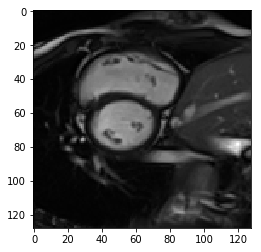

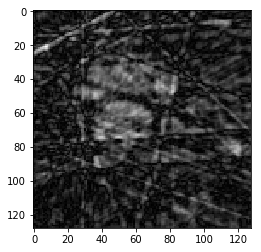

In [23]:
plt.imshow(test_truth[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(test_recon[0,0,:,:,0], cmap='gray')
plt.show()

In [24]:
print(k_test.shape)
print(test_mask.shape)
print(test_truth.shape)
print(test_recon.shape)

(222, 2, 128, 128, 20)
(222, 2, 128, 128, 20)
(222, 2, 128, 128, 20)
(222, 2, 128, 128, 20)


In [25]:
k_test = torch.from_numpy(k_test)
test_mask = torch.from_numpy(test_mask)
test_truth = torch.from_numpy(test_truth)
test_recon = torch.from_numpy(test_recon)

In [26]:
print(k_test.shape)
print(test_mask.shape)
print(test_truth.shape)
print(test_recon.shape)

torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])


In [27]:
print(k_test.dtype)
print(test_mask.dtype)
print(test_truth.dtype)
print(test_recon.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


In [28]:
mask = to_tensor_format(mask, True)

In [29]:
data_k = to_tensor_format(data_k)

In [30]:
data_recon = to_tensor_format(data_recon, True)

In [31]:
data_truth = to_tensor_format(data_truth, True)

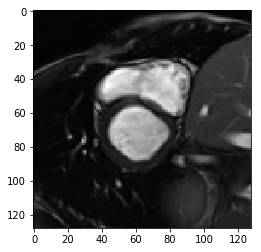

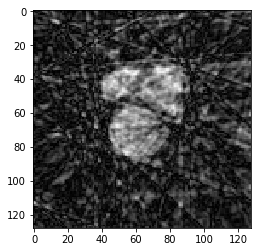

In [32]:
plt.imshow(data_truth[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(data_recon[0,0,:,:,0], cmap='gray')
plt.show()

In [33]:
print(data_k.shape)
print(mask.shape)
print(data_truth.shape)
print(data_recon.shape)

(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)


In [34]:
data_k = torch.from_numpy(data_k)
mask = torch.from_numpy(mask)
data_truth = torch.from_numpy(data_truth)
data_recon = torch.from_numpy(data_recon)

In [35]:
print(data_k.shape)
print(mask.shape)
print(data_truth.shape)
print(data_recon.shape)

torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])


In [36]:
print(data_k.dtype)
print(mask.dtype)
print(data_truth.dtype)
print(data_recon.dtype)

torch.float32
torch.float32
torch.float64
torch.float64


In [37]:
data_recon = data_recon.type(torch.float)
data_truth = data_truth.type(torch.float)

In [38]:
print(data_k.dtype)
print(mask.dtype)
print(data_truth.dtype)
print(data_recon.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


# Defining the CRNN model

In [39]:
def data_consistency(k, k_0, mask, tau=None):
    """
    k    - input in k-space
    k0   - initially sampled elements in k-space
    mask - corresponding nonzero location
    """
    if tau:  
        output = (1 - mask) * k + mask * (k + tau * k_0) / (1 + tau)
    else:  
        output = (1 - mask) * k + mask * k_0
    return output

class Data_Consistency(nn.Module):
    """
    Data Consistency layer
    See the reference for the details of this operation.
    The basic idea is that if a point is smapled, we take the linear combination
    between the CNN prediction and the original measurements, weighted by the levle of noise.
    If the point is not sampled then we use the output of the network.
    """

    def __init__(self, tau=None, norm='ortho'):
        super(Data_Consistency, self).__init__()
        self.tau = tau
        self.normalized = norm == 'ortho' # needed for FFT

    def forward(self, *input, **kwargs):
        return self.perform(*input)

    def perform(self, x, k_0, mask):
        """
        x: input in the image domain, shape: (N, 2, x, y, T)
        k_0: initially sampled k-space data
        mask: the mask we use which tells which points were sampled which were not
        """
        #2D data
        if x.dim() == 4:
            x    = x.permute(0, 2, 3, 1)
            k_0   = k_0.permute(0, 2, 3, 1)
            mask = mask.permute(0, 2, 3, 1)
        #3D data    
        elif x.dim() == 5: 
            x    = x.permute(0, 4, 2, 3, 1)
            k_0   = k_0.permute(0, 4, 2, 3, 1)
            mask = mask.permute(0, 4, 2, 3, 1)

        # See the paper for more information
        # F^T * diagoanl matrix * F * x
        k = torch.fft(x, 2, normalized=self.normalized)
        out = data_consistency(k, k_0, mask, self.tau)
        output = torch.ifft(out, 2, normalized=self.normalized)

        if x.dim() == 4:
            output = output.permute(0, 3, 1, 2)
        elif x.dim() == 5:
            output = output.permute(0, 4, 2, 3, 1)

        return output

class CRNN(nn.Module):
    """
    Convolutional recurrent units evolving over iterations only
    Parameters
    -----------------
    inputs = input of the cell, 4D tensor, shape: (N_batch, channel, width, height)
    hiddenIteration = hidden states in the iteration dimension, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    hiddenTempral = hidden states in the tmeporal dimension, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    -----------------
    output ---> hidden = our hidden representation, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    """

    def __init__(self, input_channel, hidden_channel, kernel_size):
        super(CRNN, self).__init__()
        self.kernel_size = kernel_size
        self.iteration_to_hidden = nn.Conv2d(input_channel, hidden_channel, kernel_size, padding=1)
        self.hidden_to_hidden = nn.Conv2d(hidden_channel, hidden_channel, kernel_size, padding=1)
        # add iteration hidden connection
        self.iterationHidden_to_iterationHidden = nn.Conv2d(hidden_channel, hidden_channel, kernel_size, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(hidden_channel)

    def forward(self, input, hiddenIteration, hiddenTemporal):
        """
        This performs the following operation, giving out H_l^i which is the
        hidden representation at layer l and at iteration i.
        ---------------
        H_l^i = ReLU(W_l * H_{l-1}^i + W_i * H_l^{i-1} + B_l)
        where ReLU is the non-linearity
        W_l and W_i are the filters of input_to_hidden convolutions and hidden_to_hidden convolutions respectively
        B_l is the bias term
        * is Convolution operation
        ---------------
        Also, output is batch-normalised at the end
        """
        input_to_hidden = self.iteration_to_hidden(input)
        hidden_to_hidden = self.hidden_to_hidden(hiddenTemporal)
        iterationHidden = self.iterationHidden_to_iterationHidden(hiddenIteration)

        hidden = self.relu(input_to_hidden + hidden_to_hidden + iterationHidden)
        #print(hidden.shape)
        hidden = self.batchnorm(hidden)

        return hidden

class BCRNN(nn.Module):
    """
    Bidirectional convolutional recurrent units evolving over time and iterations
    ---------------------
    inputs = input data, 5D tensor, shape: (time_steps, N_batch, channel, width, height)
    inputIteration = hidden states form the previous iteration, 5D tensor, shape: (time_steps, N_batch, channel, width, height)
    mode = If in test mode to remove the grad. False (training) or True (testing)
    ---------------------
    output---> output,
    """
    def __init__(self, input_channel, hidden_channel, kernel_size):
        super(BCRNN, self).__init__()
        self.hidden_channel = hidden_channel
        self.kernel_size = kernel_size
        self.input_channel = input_channel
        self.CRNN_model = CRNN(self.input_channel, self.hidden_channel, self.kernel_size)

    def forward(self, input, input_iteration, mode=False):
        """
        This performs the following operation, giving out H_l_t^i which is the
        hidden representation at layer l, time-step t and at iteration i.
        ---------------
        forward_H_l_t^i = ReLU(W_l * H_{l-1}_t^i + W_t * forward_H_l_{t-1}^{i}+ W_i * H_l_t^{i-1} + forward_B_l)
        backward_H_l_t^i = ReLU(W_l * H_{l-1}_t^i + W_t * backward_H_l_{t-1}^{i}+ W_i * H_l_t^{i-1} + backward_B_l)
        H_l_t^i = forward_H_l_t^i + backward_H_l_t^i
        where ReLU is the non-linearity
        B_l is the bias term
        * is Convolution operation
        W_l and W_i are the filters of input_to_hidden convolutions and hidden_to_hidden convolutions respectively
        and W_t represents the filters of recurrent convolutions evolving over time.
        forward and backward is the direction of the hidden representation.
        ---------------
        """


        T, N_batch, channels, X, Y = input.shape # T, N_batch, channels, x, y
        hidden_size = [N_batch, self.hidden_channel, X, Y]
        if mode:
            with torch.no_grad():
                initial_hidden = Variable(torch.zeros(hidden_size)).cuda()
        else:
            initial_hidden = Variable(torch.zeros(hidden_size)).cuda()

        forward = []
        backward = []
        # forward
        hidden = initial_hidden
        for i in range(T):
            hidden = self.CRNN_model(input[i], input_iteration[i], hidden)
            forward.append(hidden)

        forward = torch.cat(forward)

        # backward
        hidden = initial_hidden
        for i in range(T):
            hidden = self.CRNN_model(input[T - i - 1], input_iteration[T - i -1], hidden)

            backward.append(hidden)
        backward = torch.cat(backward[::-1])

        output = forward + backward

        if N_batch == 1:
            output = output.view(T, 1, self.hidden_channel, X, Y)

        return output


class CRNN_MRI(nn.Module):
    """
    Model for Dynamic MRI Reconstruction using Convolutional Neural Networks
    Parameters. See the paper for more information
    -----------------------
         N_channels: number of channels
         N_filters: number of filters
         kernel_size: kernel size
         N_iterations: number of iterations
         N_units: number of CRNN/BCRNN/CNN layers in each iteration
    """
    def __init__(self, N_channels=2, N_filters=64, kernel_size=3, N_iterations=10, N_units=5):

        super(CRNN_MRI, self).__init__()
        self.N_iterations = N_iterations
        self.N_units = N_units
        self.N_filters = N_filters
        self.kernel_size = kernel_size

        self.bcrnn = BCRNN(N_channels, N_filters, kernel_size)
        self.conv1_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv1_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv2_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv2_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv3_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv3_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv4_x = nn.Conv2d(N_filters, N_channels, kernel_size, padding = 1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(N_filters)
        self.batchnorm3 = nn.BatchNorm3d(N_channels)

        DC = []
        for i in range(N_iterations):
            DC.append(Data_Consistency(norm='ortho', tau=0.2))
        self.DC = DC

    def forward(self, x, k, m, mode=False):
        """
        x, y, m: input image, k-spce data, mask, shape: (N_batch, 2, x, y, T)
        mode - True: the model is in test mode, False: train mode
        """
        net = {}
        n_batch, N_channels, width, height, n_seq = x.size()
        size_h = [n_seq*n_batch, self.N_filters, width, height]
        if mode:
            with torch.no_grad():
                hid_init = Variable(torch.zeros(size_h)).cuda()
        else:
            hid_init = Variable(torch.zeros(size_h)).cuda()

        for j in range(self.N_units-1):
            net['t0_x%d'%j]=hid_init

        for i in range(1,self.N_iterations+1):

            x = x.permute(4,0,1,2,3)
            x = x.contiguous()
            net['t%d_x0' % (i - 1)] = net['t%d_x0' % (i - 1)].view(n_seq, n_batch,self.N_filters,width, height)
            net['t%d_x0'%i] = self.bcrnn(x, net['t%d_x0'%(i-1)], mode)
            net['t%d_x0'%i] = net['t%d_x0'%i].view(-1,self.N_filters,width, height)


            net['t%d_x1'%i] = self.conv1_x(net['t%d_x0'%i])
            net['t%d_h1'%i] = self.conv1_h(net['t%d_x1'%(i-1)])
            net['t%d_x1'%i] = self.relu(net['t%d_h1'%i]+net['t%d_x1'%i])
            net['t%d_x1'%i] = self.batchnorm(net['t%d_x1'%i])

            net['t%d_x2'%i] = self.conv2_x(net['t%d_x1'%i])
            net['t%d_h2'%i] = self.conv2_h(net['t%d_x2'%(i-1)])
            net['t%d_x2'%i] = self.relu(net['t%d_h2'%i]+net['t%d_x2'%i])
            net['t%d_x2'%i] = self.batchnorm(net['t%d_x2'%i])

            net['t%d_x3'%i] = self.conv3_x(net['t%d_x2'%i])
            net['t%d_h3'%i] = self.conv3_h(net['t%d_x3'%(i-1)])
            net['t%d_x3'%i] = self.relu(net['t%d_h3'%i]+net['t%d_x3'%i])
            net['t%d_x3'%i] = self.batchnorm(net['t%d_x3'%i])

            net['t%d_x4'%i] = self.conv4_x(net['t%d_x3'%i])

            x = x.view(-1,N_channels,width, height)
            net['t%d_out'%i] = x + net['t%d_x4'%i]

            net['t%d_out'%i] = net['t%d_out'%i].view(-1,n_batch, N_channels, width, height)
            net['t%d_out'%i] = net['t%d_out'%i].permute(1,2,3,4,0)
            net['t%d_out'%i].contiguous()
            net['t%d_out'%i] = self.DC[i-1].perform(net['t%d_out'%i], k, m)
            x = net['t%d_out'%i]
            #x = self.batchnorm3(x)

            # clean up i-1
            if mode:
                to_delete = [ key for key in net if ('t%d'%(i-1)) in key ]

                for elt in to_delete:
                    del net[elt]

                torch.cuda.empty_cache()

        return net['t%d_out'%i]

In [40]:
model = CRNN_MRI().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [42]:
datasets = torch.utils.data.TensorDataset(data_recon, data_truth, 
                                          data_k, mask)
train_loader = DataLoader(datasets, batch_size=1, shuffle=True)

In [43]:
test_point = test_recon[0:1]
k_point = k_test[0:1]
mask_point = test_mask[0:1]

test_point = test_point.to(device)
k_point = k_point.to(device)
mask_point = mask_point.to(device)

In [46]:
import datetime

loss_vec = []
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_crnn_20und_epoch__%d.pth'%0)
    for epoch in range(1, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels, k, m in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            k = k.to(device)
            m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs, k, m)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point, k_point, mask_point, mode=True)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(np.sqrt(prediction[0,0,:,:,0]**2 + prediction[0,1,:,:,0]**2), cmap='gray')
        plt.show()
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_crnn_20und_epoch_%d.pth'%epoch)
        
    

saving epoch {0}
Epoch: 1, Iteration: 1, Loss: 0.009687219746410847, time: 2019-08-03 02:01:24.664542
Epoch: 1, Iteration: 101, Loss: 0.7991779954172671, time: 2019-08-03 02:03:22.468329
Epoch: 1, Iteration: 201, Loss: 1.50869613699615, time: 2019-08-03 02:05:20.123594
Epoch: 1, Iteration: 301, Loss: 2.0607060375623405, time: 2019-08-03 02:07:17.464298
Epoch: 1, Iteration: 401, Loss: 2.5698750012088567, time: 2019-08-03 02:09:14.640295
Epoch: 1, Iteration: 501, Loss: 3.0808115049730986, time: 2019-08-03 02:11:11.831390
Epoch: 1, Iteration: 601, Loss: 3.5786530119366944, time: 2019-08-03 02:13:09.067460
Epoch: 1, Iteration: 701, Loss: 4.057417569682002, time: 2019-08-03 02:15:06.337839
Epoch: 1, Iteration: 801, Loss: 4.451307354262099, time: 2019-08-03 02:17:03.533724
Epoch: 1, Iteration: 901, Loss: 4.834352568956092, time: 2019-08-03 02:19:00.823934
Epoch: 1, Iteration: 1001, Loss: 5.234913049614988, time: 2019-08-03 02:20:57.957758
Epoch: 1, Iteration: 1101, Loss: 5.627871306729503, t

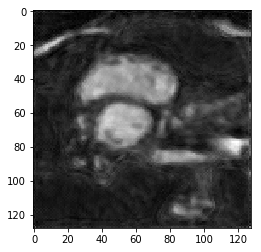

saving epoch {1}
Epoch: 2, Iteration: 1, Loss: 0.00537683442234993, time: 2019-08-03 02:24:55.051421
Epoch: 2, Iteration: 101, Loss: 0.34919986547902226, time: 2019-08-03 02:26:55.951479
Epoch: 2, Iteration: 201, Loss: 0.7243797985138372, time: 2019-08-03 02:28:56.918558
Epoch: 2, Iteration: 301, Loss: 1.068940530414693, time: 2019-08-03 02:30:58.128765
Epoch: 2, Iteration: 401, Loss: 1.4124405889306217, time: 2019-08-03 02:33:00.210991
Epoch: 2, Iteration: 501, Loss: 1.7112330456729978, time: 2019-08-03 02:35:01.583937
Epoch: 2, Iteration: 601, Loss: 2.019000038388185, time: 2019-08-03 02:37:03.293341
Epoch: 2, Iteration: 701, Loss: 2.3616652343189344, time: 2019-08-03 02:39:04.051914
Epoch: 2, Iteration: 801, Loss: 2.6902912546647713, time: 2019-08-03 02:41:04.495936
Epoch: 2, Iteration: 901, Loss: 3.0136933310423046, time: 2019-08-03 02:43:06.424586
Epoch: 2, Iteration: 1001, Loss: 3.3348929543280974, time: 2019-08-03 02:45:07.842220
Epoch: 2, Iteration: 1101, Loss: 3.62927664571907

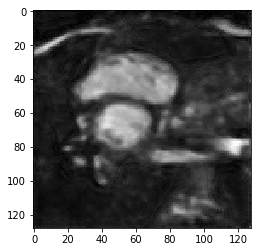

saving epoch {2}
Epoch: 3, Iteration: 1, Loss: 0.006636192090809345, time: 2019-08-03 02:49:11.363251
Epoch: 3, Iteration: 101, Loss: 0.2967459784122184, time: 2019-08-03 02:51:12.448109
Epoch: 3, Iteration: 201, Loss: 0.592846663785167, time: 2019-08-03 02:53:13.230903
Epoch: 3, Iteration: 301, Loss: 0.896199838258326, time: 2019-08-03 02:55:14.138811
Epoch: 3, Iteration: 401, Loss: 1.1611986400093883, time: 2019-08-03 02:57:15.535606
Epoch: 3, Iteration: 501, Loss: 1.4683646463090554, time: 2019-08-03 02:59:15.052838
Epoch: 3, Iteration: 601, Loss: 1.7537794501986355, time: 2019-08-03 03:01:14.894156
Epoch: 3, Iteration: 701, Loss: 2.034477351466194, time: 2019-08-03 03:03:13.382073
Epoch: 3, Iteration: 801, Loss: 2.2959973817924038, time: 2019-08-03 03:05:12.210942
Epoch: 3, Iteration: 901, Loss: 2.5863403120310977, time: 2019-08-03 03:07:09.857799
Epoch: 3, Iteration: 1001, Loss: 2.8346546767279506, time: 2019-08-03 03:09:07.244919
Epoch: 3, Iteration: 1101, Loss: 3.093708942644298

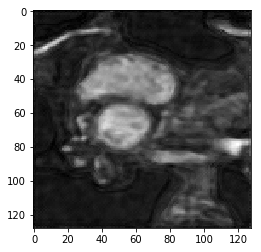

saving epoch {3}
Epoch: 4, Iteration: 1, Loss: 0.004476104862987995, time: 2019-08-03 03:13:02.471639
Epoch: 4, Iteration: 101, Loss: 0.27520316280424595, time: 2019-08-03 03:14:59.660970
Epoch: 4, Iteration: 201, Loss: 0.5404586648801342, time: 2019-08-03 03:16:56.791228
Epoch: 4, Iteration: 301, Loss: 0.792157928342931, time: 2019-08-03 03:18:53.927453
Epoch: 4, Iteration: 401, Loss: 1.0439186601433903, time: 2019-08-03 03:20:51.062202
Epoch: 4, Iteration: 501, Loss: 1.3086539715295658, time: 2019-08-03 03:22:48.181407
Epoch: 4, Iteration: 601, Loss: 1.5659199097426608, time: 2019-08-03 03:24:46.898445
Epoch: 4, Iteration: 701, Loss: 1.8286769582191482, time: 2019-08-03 03:26:47.647753
Epoch: 4, Iteration: 801, Loss: 2.0933877256466076, time: 2019-08-03 03:28:48.575470
Epoch: 4, Iteration: 901, Loss: 2.3342573810368776, time: 2019-08-03 03:30:49.727917
Epoch: 4, Iteration: 1001, Loss: 2.5980109956581146, time: 2019-08-03 03:32:52.629496
Epoch: 4, Iteration: 1101, Loss: 2.832709623151

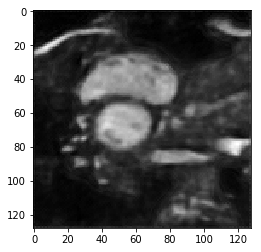

saving epoch {4}
Epoch: 5, Iteration: 1, Loss: 0.0026716680731624365, time: 2019-08-03 03:36:55.025927
Epoch: 5, Iteration: 101, Loss: 0.2653003801824525, time: 2019-08-03 03:38:55.146056
Epoch: 5, Iteration: 201, Loss: 0.5003542887279764, time: 2019-08-03 03:40:56.254988
Epoch: 5, Iteration: 301, Loss: 0.7225750720826909, time: 2019-08-03 03:42:55.743517
Epoch: 5, Iteration: 401, Loss: 0.9658475882606581, time: 2019-08-03 03:44:55.227674
Epoch: 5, Iteration: 501, Loss: 1.2361778996419162, time: 2019-08-03 03:46:54.755202
Epoch: 5, Iteration: 601, Loss: 1.4838344373274595, time: 2019-08-03 03:48:54.874159
Epoch: 5, Iteration: 701, Loss: 1.7334911181824282, time: 2019-08-03 03:50:55.242481
Epoch: 5, Iteration: 801, Loss: 1.961976416176185, time: 2019-08-03 03:52:55.606682
Epoch: 5, Iteration: 901, Loss: 2.1908744699903764, time: 2019-08-03 03:54:55.670034
Epoch: 5, Iteration: 1001, Loss: 2.4192096299375407, time: 2019-08-03 03:56:56.314558
Epoch: 5, Iteration: 1101, Loss: 2.660075702064

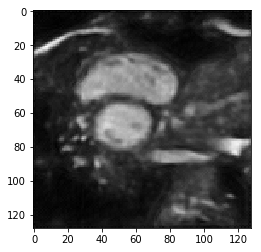

saving epoch {5}
Epoch: 6, Iteration: 1, Loss: 0.002193916356191039, time: 2019-08-03 04:00:58.361494
Epoch: 6, Iteration: 101, Loss: 0.25009866774780676, time: 2019-08-03 04:02:58.433277
Epoch: 6, Iteration: 201, Loss: 0.519639034231659, time: 2019-08-03 04:04:58.485005
Epoch: 6, Iteration: 301, Loss: 0.7759285788633861, time: 2019-08-03 04:06:58.858176
Epoch: 6, Iteration: 401, Loss: 1.015384878788609, time: 2019-08-03 04:08:58.145680
Epoch: 6, Iteration: 501, Loss: 1.2502093505463563, time: 2019-08-03 04:10:58.393071
Epoch: 6, Iteration: 601, Loss: 1.4954355722293258, time: 2019-08-03 04:12:58.315928
Epoch: 6, Iteration: 701, Loss: 1.7024676644941792, time: 2019-08-03 04:14:56.150065
Epoch: 6, Iteration: 801, Loss: 1.925247713108547, time: 2019-08-03 04:16:53.655350
Epoch: 6, Iteration: 901, Loss: 2.161340885097161, time: 2019-08-03 04:18:51.017695
Epoch: 6, Iteration: 1001, Loss: 2.392617482400965, time: 2019-08-03 04:20:48.210921
Epoch: 6, Iteration: 1101, Loss: 2.625921374943573,

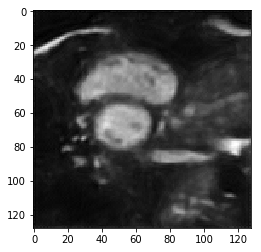

saving epoch {6}
Epoch: 7, Iteration: 1, Loss: 0.0012080523883923888, time: 2019-08-03 04:24:43.444237
Epoch: 7, Iteration: 101, Loss: 0.20837686018785462, time: 2019-08-03 04:26:40.657660
Epoch: 7, Iteration: 201, Loss: 0.4416052757296711, time: 2019-08-03 04:28:37.874799
Epoch: 7, Iteration: 301, Loss: 0.6607305268989876, time: 2019-08-03 04:30:35.058690
Epoch: 7, Iteration: 401, Loss: 0.9105650095734745, time: 2019-08-03 04:32:32.314043
Epoch: 7, Iteration: 501, Loss: 1.1494667758233845, time: 2019-08-03 04:34:29.468537
Epoch: 7, Iteration: 601, Loss: 1.4244727581972256, time: 2019-08-03 04:36:26.670790
Epoch: 7, Iteration: 701, Loss: 1.6495360900298692, time: 2019-08-03 04:38:23.863943
Epoch: 7, Iteration: 801, Loss: 1.8893333186861128, time: 2019-08-03 04:40:21.000813
Epoch: 7, Iteration: 901, Loss: 2.119331058987882, time: 2019-08-03 04:42:18.146520
Epoch: 7, Iteration: 1001, Loss: 2.34298638778273, time: 2019-08-03 04:44:15.290442
Epoch: 7, Iteration: 1101, Loss: 2.5897276911418

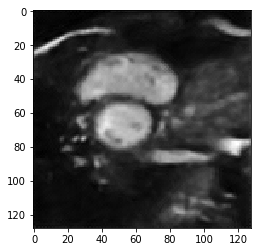

saving epoch {7}
Epoch: 8, Iteration: 1, Loss: 0.0018325680866837502, time: 2019-08-03 04:48:10.563881
Epoch: 8, Iteration: 101, Loss: 0.21146371273789555, time: 2019-08-03 04:50:07.769181
Epoch: 8, Iteration: 201, Loss: 0.4204186933930032, time: 2019-08-03 04:52:04.960961
Epoch: 8, Iteration: 301, Loss: 0.6170958301518112, time: 2019-08-03 04:54:02.149697
Epoch: 8, Iteration: 401, Loss: 0.8116772182984278, time: 2019-08-03 04:55:59.367324
Epoch: 8, Iteration: 501, Loss: 1.0319674015045166, time: 2019-08-03 04:57:56.594936
Epoch: 8, Iteration: 601, Loss: 1.2322881550062448, time: 2019-08-03 04:59:53.821797
Epoch: 8, Iteration: 701, Loss: 1.4427424535970204, time: 2019-08-03 05:01:51.052866
Epoch: 8, Iteration: 801, Loss: 1.6717339292517863, time: 2019-08-03 05:03:48.245212
Epoch: 8, Iteration: 901, Loss: 1.9270323646487668, time: 2019-08-03 05:05:45.449540
Epoch: 8, Iteration: 1001, Loss: 2.1373536559403874, time: 2019-08-03 05:07:42.694891
Epoch: 8, Iteration: 1101, Loss: 2.3438578671

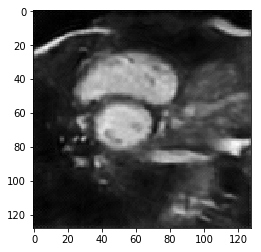

saving epoch {8}
Epoch: 9, Iteration: 1, Loss: 0.0017653104150667787, time: 2019-08-03 05:11:37.956293
Epoch: 9, Iteration: 101, Loss: 0.21722830773796886, time: 2019-08-03 05:13:35.145113
Epoch: 9, Iteration: 201, Loss: 0.4210832059616223, time: 2019-08-03 05:15:32.329802
Epoch: 9, Iteration: 301, Loss: 0.6544307691510767, time: 2019-08-03 05:17:29.484720
Epoch: 9, Iteration: 401, Loss: 0.8489415684598498, time: 2019-08-03 05:19:28.000631
Epoch: 9, Iteration: 501, Loss: 1.0760931047261693, time: 2019-08-03 05:21:26.844399
Epoch: 9, Iteration: 601, Loss: 1.3064566688262857, time: 2019-08-03 05:23:25.628293
Epoch: 9, Iteration: 701, Loss: 1.5034728477476165, time: 2019-08-03 05:25:26.786692
Epoch: 9, Iteration: 801, Loss: 1.7084743364830501, time: 2019-08-03 05:27:28.162504
Epoch: 9, Iteration: 901, Loss: 1.883219447627198, time: 2019-08-03 05:29:29.073340
Epoch: 9, Iteration: 1001, Loss: 2.081847252207808, time: 2019-08-03 05:31:31.437272
Epoch: 9, Iteration: 1101, Loss: 2.294507153332

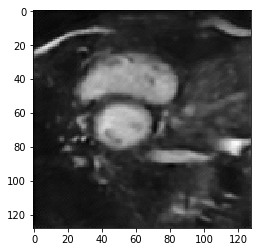

saving epoch {9}
Epoch: 10, Iteration: 1, Loss: 0.0027908976189792156, time: 2019-08-03 05:35:35.755555
Epoch: 10, Iteration: 101, Loss: 0.187280006299261, time: 2019-08-03 05:37:37.079578
Epoch: 10, Iteration: 201, Loss: 0.3636618497548625, time: 2019-08-03 05:39:37.999024
Epoch: 10, Iteration: 301, Loss: 0.5408983370871283, time: 2019-08-03 05:41:39.731014
Epoch: 10, Iteration: 401, Loss: 0.7498261792352423, time: 2019-08-03 05:43:41.898545
Epoch: 10, Iteration: 501, Loss: 0.9241405794746242, time: 2019-08-03 05:45:42.999174
Epoch: 10, Iteration: 601, Loss: 1.1233262201421894, time: 2019-08-03 05:47:43.854831
Epoch: 10, Iteration: 701, Loss: 1.316236554121133, time: 2019-08-03 05:49:44.903361
Epoch: 10, Iteration: 801, Loss: 1.506454695481807, time: 2019-08-03 05:51:46.975515
Epoch: 10, Iteration: 901, Loss: 1.6988168606185354, time: 2019-08-03 05:53:48.166750
Epoch: 10, Iteration: 1001, Loss: 1.8908318622852676, time: 2019-08-03 05:55:49.394753
Epoch: 10, Iteration: 1101, Loss: 2.09

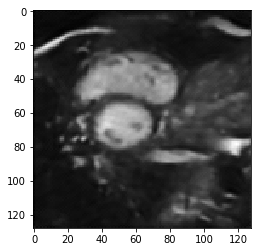

saving epoch {10}
Epoch: 11, Iteration: 1, Loss: 0.0011492578778415918, time: 2019-08-03 05:59:54.205632
Epoch: 11, Iteration: 101, Loss: 0.1884664020035416, time: 2019-08-03 06:01:56.688974
Epoch: 11, Iteration: 201, Loss: 0.3855547596467659, time: 2019-08-03 06:03:57.733861
Epoch: 11, Iteration: 301, Loss: 0.5460902674822137, time: 2019-08-03 06:05:58.198909
Epoch: 11, Iteration: 401, Loss: 0.7463713695760816, time: 2019-08-03 06:07:59.782594
Epoch: 11, Iteration: 501, Loss: 0.9437927579274401, time: 2019-08-03 06:10:00.832370
Epoch: 11, Iteration: 601, Loss: 1.120160113554448, time: 2019-08-03 06:12:00.746574
Epoch: 11, Iteration: 701, Loss: 1.2896210990729742, time: 2019-08-03 06:14:01.578416
Epoch: 11, Iteration: 801, Loss: 1.4639033623971045, time: 2019-08-03 06:16:02.599152
Epoch: 11, Iteration: 901, Loss: 1.6277996606077068, time: 2019-08-03 06:18:03.961010
Epoch: 11, Iteration: 1001, Loss: 1.81069192441646, time: 2019-08-03 06:20:04.692001
Epoch: 11, Iteration: 1101, Loss: 1.9

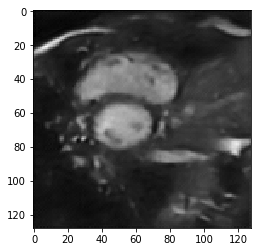

saving epoch {11}
Epoch: 12, Iteration: 1, Loss: 0.0014213783433660865, time: 2019-08-03 06:24:03.271320
Epoch: 12, Iteration: 101, Loss: 0.1576580051041674, time: 2019-08-03 06:26:06.123496
Epoch: 12, Iteration: 201, Loss: 0.34297094561043195, time: 2019-08-03 06:28:06.554421
Epoch: 12, Iteration: 301, Loss: 0.49990629058447666, time: 2019-08-03 06:30:06.758444
Epoch: 12, Iteration: 401, Loss: 0.6660789659654256, time: 2019-08-03 06:32:06.719662
Epoch: 12, Iteration: 501, Loss: 0.8227353468828369, time: 2019-08-03 06:34:07.662277
Epoch: 12, Iteration: 601, Loss: 0.9689805841480847, time: 2019-08-03 06:36:08.996004
Epoch: 12, Iteration: 701, Loss: 1.1881825152377132, time: 2019-08-03 06:38:08.220725
Epoch: 12, Iteration: 801, Loss: 1.345300962770125, time: 2019-08-03 06:40:07.063283
Epoch: 12, Iteration: 901, Loss: 1.5192914483195636, time: 2019-08-03 06:42:06.470932
Epoch: 12, Iteration: 1001, Loss: 1.6693242987676058, time: 2019-08-03 06:44:06.261238
Epoch: 12, Iteration: 1101, Loss:

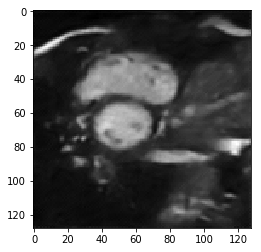

saving epoch {12}
Epoch: 13, Iteration: 1, Loss: 0.001809456734918058, time: 2019-08-03 06:48:06.516560
Epoch: 13, Iteration: 101, Loss: 0.15371119161136448, time: 2019-08-03 06:50:06.319205
Epoch: 13, Iteration: 201, Loss: 0.29979656520299613, time: 2019-08-03 06:52:04.013362
Epoch: 13, Iteration: 301, Loss: 0.438957778562326, time: 2019-08-03 06:54:01.305149
Epoch: 13, Iteration: 401, Loss: 0.6062605684855953, time: 2019-08-03 06:55:58.551758
Epoch: 13, Iteration: 501, Loss: 0.7659758585505188, time: 2019-08-03 06:57:55.836889
Epoch: 13, Iteration: 601, Loss: 0.9007889117347077, time: 2019-08-03 06:59:53.035676
Epoch: 13, Iteration: 701, Loss: 1.0575149443466216, time: 2019-08-03 07:01:50.283438
Epoch: 13, Iteration: 801, Loss: 1.1910647010663524, time: 2019-08-03 07:03:47.564683
Epoch: 13, Iteration: 901, Loss: 1.323319927265402, time: 2019-08-03 07:05:44.811520
Epoch: 13, Iteration: 1001, Loss: 1.4756493056192994, time: 2019-08-03 07:07:42.078185
Epoch: 13, Iteration: 1101, Loss: 1

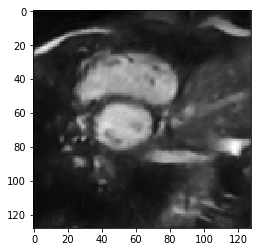

saving epoch {13}
Epoch: 14, Iteration: 1, Loss: 0.001838131109252572, time: 2019-08-03 07:11:38.049774
Epoch: 14, Iteration: 101, Loss: 0.13000961142824963, time: 2019-08-03 07:13:38.757997
Epoch: 14, Iteration: 201, Loss: 0.3059560112305917, time: 2019-08-03 07:15:39.828513
Epoch: 14, Iteration: 301, Loss: 0.4426031047478318, time: 2019-08-03 07:17:41.195554
Epoch: 14, Iteration: 401, Loss: 0.5867778083484154, time: 2019-08-03 07:19:43.888219
Epoch: 14, Iteration: 501, Loss: 0.7268888732069172, time: 2019-08-03 07:21:45.565214
Epoch: 14, Iteration: 601, Loss: 0.8627470971259754, time: 2019-08-03 07:23:46.625851
Epoch: 14, Iteration: 701, Loss: 0.9815206541970838, time: 2019-08-03 07:25:47.489175
Epoch: 14, Iteration: 801, Loss: 1.1162236488016788, time: 2019-08-03 07:27:48.908018
Epoch: 14, Iteration: 901, Loss: 1.2337808038282674, time: 2019-08-03 07:29:49.954250
Epoch: 14, Iteration: 1001, Loss: 1.3569442744774278, time: 2019-08-03 07:31:50.684442
Epoch: 14, Iteration: 1101, Loss: 

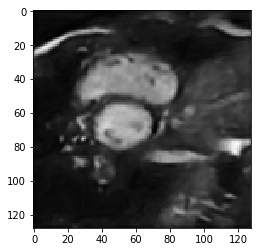

saving epoch {14}
Epoch: 15, Iteration: 1, Loss: 0.0009237043559551239, time: 2019-08-03 07:35:52.672453
Epoch: 15, Iteration: 101, Loss: 0.11280943563906476, time: 2019-08-03 07:37:52.467790
Epoch: 15, Iteration: 201, Loss: 0.24119182117283344, time: 2019-08-03 07:39:52.132247
Epoch: 15, Iteration: 301, Loss: 0.36531895847292617, time: 2019-08-03 07:41:50.492575
Epoch: 15, Iteration: 401, Loss: 0.49244403388001956, time: 2019-08-03 07:43:48.516852
Epoch: 15, Iteration: 501, Loss: 0.6107142406981438, time: 2019-08-03 07:45:46.465771
Epoch: 15, Iteration: 601, Loss: 0.7252077912853565, time: 2019-08-03 07:47:43.874906
Epoch: 15, Iteration: 701, Loss: 0.8778756087122019, time: 2019-08-03 07:49:41.282976
Epoch: 15, Iteration: 801, Loss: 1.0043444957700558, time: 2019-08-03 07:51:38.600439
Epoch: 15, Iteration: 901, Loss: 1.1152741329278797, time: 2019-08-03 07:53:35.987175
Epoch: 15, Iteration: 1001, Loss: 1.2298230497981422, time: 2019-08-03 07:55:33.407436
Epoch: 15, Iteration: 1101, Lo

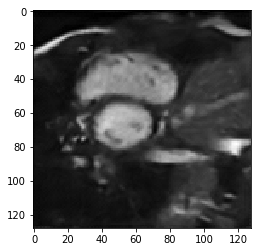

saving epoch {15}
Epoch: 16, Iteration: 1, Loss: 0.0006493263645097613, time: 2019-08-03 07:59:28.976569
Epoch: 16, Iteration: 101, Loss: 0.13183515559649095, time: 2019-08-03 08:01:26.507959
Epoch: 16, Iteration: 201, Loss: 0.25035549339372665, time: 2019-08-03 08:03:27.052651
Epoch: 16, Iteration: 301, Loss: 0.37880572845460847, time: 2019-08-03 08:05:27.653972
Epoch: 16, Iteration: 401, Loss: 0.48788757622241974, time: 2019-08-03 08:07:28.639443
Epoch: 16, Iteration: 501, Loss: 0.601874044892611, time: 2019-08-03 08:09:30.698492
Epoch: 16, Iteration: 601, Loss: 0.7427157484053168, time: 2019-08-03 08:11:31.899484
Epoch: 16, Iteration: 701, Loss: 0.8901308619242627, time: 2019-08-03 08:13:33.461284
Epoch: 16, Iteration: 801, Loss: 1.0253134725498967, time: 2019-08-03 08:15:36.131129
Epoch: 16, Iteration: 901, Loss: 1.1521102071856149, time: 2019-08-03 08:17:36.655855
Epoch: 16, Iteration: 1001, Loss: 1.2716263032634743, time: 2019-08-03 08:19:38.074721
Epoch: 16, Iteration: 1101, Los

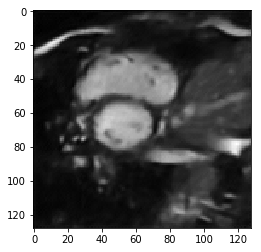

saving epoch {16}
Epoch: 17, Iteration: 1, Loss: 0.0009156285086646676, time: 2019-08-03 08:23:42.148271
Epoch: 17, Iteration: 101, Loss: 0.12697214158833958, time: 2019-08-03 08:25:41.701656
Epoch: 17, Iteration: 201, Loss: 0.22783648027689196, time: 2019-08-03 08:27:42.850621
Epoch: 17, Iteration: 301, Loss: 0.3323419675871264, time: 2019-08-03 08:29:42.885489
Epoch: 17, Iteration: 401, Loss: 0.4297154464002233, time: 2019-08-03 08:31:43.493893
Epoch: 17, Iteration: 501, Loss: 0.5393285344762262, time: 2019-08-03 08:33:42.890390
Epoch: 17, Iteration: 601, Loss: 0.6422727343742736, time: 2019-08-03 08:35:40.800324
Epoch: 17, Iteration: 701, Loss: 0.7454148223914672, time: 2019-08-03 08:37:38.297914
Epoch: 17, Iteration: 801, Loss: 0.8626466654823162, time: 2019-08-03 08:39:35.740722
Epoch: 17, Iteration: 901, Loss: 0.9777274871012196, time: 2019-08-03 08:41:33.028867
Epoch: 17, Iteration: 1001, Loss: 1.0882069139624946, time: 2019-08-03 08:43:30.347285
Epoch: 17, Iteration: 1101, Loss

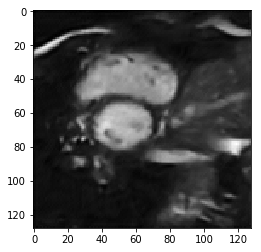

saving epoch {17}
Epoch: 18, Iteration: 1, Loss: 0.0010269758058711886, time: 2019-08-03 08:47:25.864932
Epoch: 18, Iteration: 101, Loss: 0.1154587741184514, time: 2019-08-03 08:49:23.004023
Epoch: 18, Iteration: 201, Loss: 0.22631770782754757, time: 2019-08-03 08:51:20.143968
Epoch: 18, Iteration: 301, Loss: 0.3356330343231093, time: 2019-08-03 08:53:17.312542
Epoch: 18, Iteration: 401, Loss: 0.4781693049299065, time: 2019-08-03 08:55:14.475988
Epoch: 18, Iteration: 501, Loss: 0.5879873480298556, time: 2019-08-03 08:57:11.640199
Epoch: 18, Iteration: 601, Loss: 0.6919578957604244, time: 2019-08-03 08:59:08.821732
Epoch: 18, Iteration: 701, Loss: 0.7855565919890068, time: 2019-08-03 09:01:05.977094
Epoch: 18, Iteration: 801, Loss: 0.8948528128385078, time: 2019-08-03 09:03:03.097213
Epoch: 18, Iteration: 901, Loss: 0.9923713028256316, time: 2019-08-03 09:05:00.199602
Epoch: 18, Iteration: 1001, Loss: 1.093172954802867, time: 2019-08-03 09:06:57.355694
Epoch: 18, Iteration: 1101, Loss: 

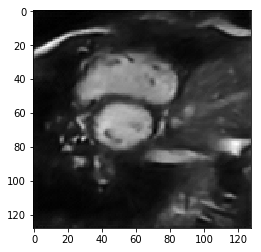

saving epoch {18}
Epoch: 19, Iteration: 1, Loss: 0.00107133062556386, time: 2019-08-03 09:10:52.500018
Epoch: 19, Iteration: 101, Loss: 0.09751405997667462, time: 2019-08-03 09:12:49.625606
Epoch: 19, Iteration: 201, Loss: 0.20682815779582597, time: 2019-08-03 09:14:46.756256
Epoch: 19, Iteration: 301, Loss: 0.3101457221491728, time: 2019-08-03 09:16:43.903314
Epoch: 19, Iteration: 401, Loss: 0.4072486462537199, time: 2019-08-03 09:18:41.001466
Epoch: 19, Iteration: 501, Loss: 0.5107716172060464, time: 2019-08-03 09:20:38.175130
Epoch: 19, Iteration: 601, Loss: 0.6071404279209673, time: 2019-08-03 09:22:35.363574
Epoch: 19, Iteration: 701, Loss: 0.7074200120114256, time: 2019-08-03 09:24:32.545462
Epoch: 19, Iteration: 801, Loss: 0.8049391067761462, time: 2019-08-03 09:26:29.648326
Epoch: 19, Iteration: 901, Loss: 0.9262566395045724, time: 2019-08-03 09:28:26.824144
Epoch: 19, Iteration: 1001, Loss: 1.0398880110296886, time: 2019-08-03 09:30:23.987768
Epoch: 19, Iteration: 1101, Loss: 

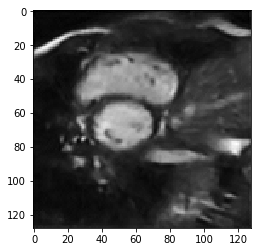

saving epoch {19}
Epoch: 20, Iteration: 1, Loss: 0.0008302024798467755, time: 2019-08-03 09:34:19.181248
Epoch: 20, Iteration: 101, Loss: 0.1034407468396239, time: 2019-08-03 09:36:16.313545
Epoch: 20, Iteration: 201, Loss: 0.20242217314080335, time: 2019-08-03 09:38:13.482601
Epoch: 20, Iteration: 301, Loss: 0.3236141798843164, time: 2019-08-03 09:40:10.590733
Epoch: 20, Iteration: 401, Loss: 0.43401648639701307, time: 2019-08-03 09:42:07.726808
Epoch: 20, Iteration: 501, Loss: 0.5495765047089662, time: 2019-08-03 09:44:04.869263
Epoch: 20, Iteration: 601, Loss: 0.6561791389540303, time: 2019-08-03 09:46:01.972347
Epoch: 20, Iteration: 701, Loss: 0.7600723052746616, time: 2019-08-03 09:47:59.141202
Epoch: 20, Iteration: 801, Loss: 0.8658292004547548, time: 2019-08-03 09:49:56.283465
Epoch: 20, Iteration: 901, Loss: 0.9572075495671015, time: 2019-08-03 09:51:53.393692
Epoch: 20, Iteration: 1001, Loss: 1.0500984656100627, time: 2019-08-03 09:53:50.507274
Epoch: 20, Iteration: 1101, Loss

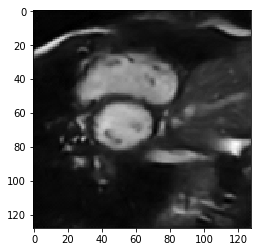

saving epoch {20}
Epoch: 21, Iteration: 1, Loss: 0.0005743718356825411, time: 2019-08-03 09:57:45.563119
Epoch: 21, Iteration: 101, Loss: 0.10358970460947603, time: 2019-08-03 09:59:42.713092
Epoch: 21, Iteration: 201, Loss: 0.2121494968305342, time: 2019-08-03 10:01:39.912198
Epoch: 21, Iteration: 301, Loss: 0.3016002628719434, time: 2019-08-03 10:03:37.103075
Epoch: 21, Iteration: 401, Loss: 0.4205585842137225, time: 2019-08-03 10:05:34.222888
Epoch: 21, Iteration: 501, Loss: 0.5210288716189098, time: 2019-08-03 10:07:31.366350
Epoch: 21, Iteration: 601, Loss: 0.6257233969517983, time: 2019-08-03 10:09:28.541187
Epoch: 21, Iteration: 701, Loss: 0.7319218644988723, time: 2019-08-03 10:11:25.691290
Epoch: 21, Iteration: 801, Loss: 0.8303544749505818, time: 2019-08-03 10:13:22.863106
Epoch: 21, Iteration: 901, Loss: 0.9267766241391655, time: 2019-08-03 10:15:20.120112
Epoch: 21, Iteration: 1001, Loss: 1.015520060842391, time: 2019-08-03 10:17:17.304163
Epoch: 21, Iteration: 1101, Loss: 

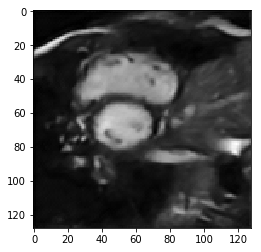

saving epoch {21}
Epoch: 22, Iteration: 1, Loss: 0.0008721530321054161, time: 2019-08-03 10:21:12.504446
Epoch: 22, Iteration: 101, Loss: 0.09135111304931343, time: 2019-08-03 10:23:09.655729
Epoch: 22, Iteration: 201, Loss: 0.18042011192301288, time: 2019-08-03 10:25:06.802725
Epoch: 22, Iteration: 301, Loss: 0.28139957672101445, time: 2019-08-03 10:27:03.952595
Epoch: 22, Iteration: 401, Loss: 0.37186676924466155, time: 2019-08-03 10:29:01.125177
Epoch: 22, Iteration: 501, Loss: 0.45586670012562536, time: 2019-08-03 10:30:58.258272
Epoch: 22, Iteration: 601, Loss: 0.552183287742082, time: 2019-08-03 10:32:55.433896
Epoch: 22, Iteration: 701, Loss: 0.6379660764941946, time: 2019-08-03 10:34:52.579877
Epoch: 22, Iteration: 801, Loss: 0.7332241240947042, time: 2019-08-03 10:36:49.726547
Epoch: 22, Iteration: 901, Loss: 0.8341470620362088, time: 2019-08-03 10:38:46.887005
Epoch: 22, Iteration: 1001, Loss: 0.9332755462091882, time: 2019-08-03 10:40:44.067730
Epoch: 22, Iteration: 1101, Lo

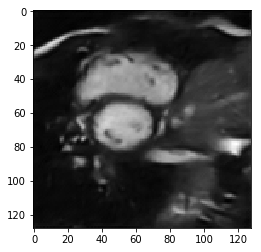

saving epoch {22}
Epoch: 23, Iteration: 1, Loss: 0.00040332000935450196, time: 2019-08-03 10:44:39.213831
Epoch: 23, Iteration: 101, Loss: 0.09718429812346585, time: 2019-08-03 10:46:36.406371
Epoch: 23, Iteration: 201, Loss: 0.18978675588732585, time: 2019-08-03 10:48:33.571829
Epoch: 23, Iteration: 301, Loss: 0.28535083070164546, time: 2019-08-03 10:50:30.812491
Epoch: 23, Iteration: 401, Loss: 0.37992781391949393, time: 2019-08-03 10:52:28.012110
Epoch: 23, Iteration: 501, Loss: 0.4679045420489274, time: 2019-08-03 10:54:25.195447
Epoch: 23, Iteration: 601, Loss: 0.5501825780665968, time: 2019-08-03 10:56:22.445184
Epoch: 23, Iteration: 701, Loss: 0.6464925358595792, time: 2019-08-03 10:58:19.591279
Epoch: 23, Iteration: 801, Loss: 0.7473334651440382, time: 2019-08-03 11:00:16.802887
Epoch: 23, Iteration: 901, Loss: 0.8363885424332693, time: 2019-08-03 11:02:13.905313
Epoch: 23, Iteration: 1001, Loss: 0.9209010377526283, time: 2019-08-03 11:04:11.063195
Epoch: 23, Iteration: 1101, L

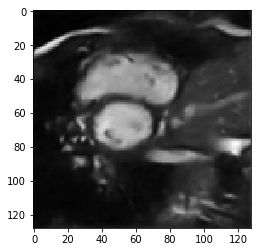

saving epoch {23}
Epoch: 24, Iteration: 1, Loss: 0.0008100979030132294, time: 2019-08-03 11:08:06.249636
Epoch: 24, Iteration: 101, Loss: 0.09624645608710125, time: 2019-08-03 11:10:03.404967
Epoch: 24, Iteration: 201, Loss: 0.18706398527137935, time: 2019-08-03 11:12:00.633839
Epoch: 24, Iteration: 301, Loss: 0.2903284546919167, time: 2019-08-03 11:13:57.771075
Epoch: 24, Iteration: 401, Loss: 0.3855433035059832, time: 2019-08-03 11:15:55.022309
Epoch: 24, Iteration: 501, Loss: 0.4791488500777632, time: 2019-08-03 11:17:52.284257
Epoch: 24, Iteration: 601, Loss: 0.5643995362042915, time: 2019-08-03 11:19:50.243947
Epoch: 24, Iteration: 701, Loss: 0.6500554644444492, time: 2019-08-03 11:21:50.046767
Epoch: 24, Iteration: 801, Loss: 0.7383342129178345, time: 2019-08-03 11:23:51.277452
Epoch: 24, Iteration: 901, Loss: 0.818165176169714, time: 2019-08-03 11:25:52.661158
Epoch: 24, Iteration: 1001, Loss: 0.9182504904747475, time: 2019-08-03 11:27:53.954208
Epoch: 24, Iteration: 1101, Loss:

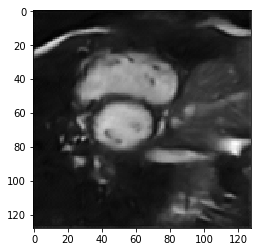

saving epoch {24}
Epoch: 25, Iteration: 1, Loss: 0.0009977864101529121, time: 2019-08-03 11:31:56.416950
Epoch: 25, Iteration: 101, Loss: 0.08773046379792504, time: 2019-08-03 11:33:56.237095
Epoch: 25, Iteration: 201, Loss: 0.17090218339581043, time: 2019-08-03 11:35:56.054795
Epoch: 25, Iteration: 301, Loss: 0.25897366672870703, time: 2019-08-03 11:37:55.875969
Epoch: 25, Iteration: 401, Loss: 0.3429017269227188, time: 2019-08-03 11:39:57.605279
Epoch: 25, Iteration: 501, Loss: 0.4324475912435446, time: 2019-08-03 11:41:59.127901
Epoch: 25, Iteration: 601, Loss: 0.5190280589158647, time: 2019-08-03 11:44:00.410941
Epoch: 25, Iteration: 701, Loss: 0.6152412392548285, time: 2019-08-03 11:46:02.326426
Epoch: 25, Iteration: 801, Loss: 0.715253393893363, time: 2019-08-03 11:48:03.792242
Epoch: 25, Iteration: 901, Loss: 0.8086544526158832, time: 2019-08-03 11:50:04.466411
Epoch: 25, Iteration: 1001, Loss: 0.8946937607834116, time: 2019-08-03 11:52:02.790188
Epoch: 25, Iteration: 1101, Loss

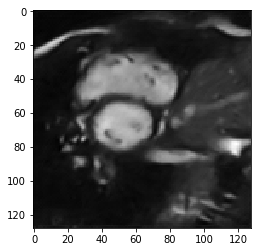

saving epoch {25}
Epoch: 26, Iteration: 1, Loss: 0.00048394236364401877, time: 2019-08-03 11:55:59.576776
Epoch: 26, Iteration: 101, Loss: 0.083987841848284, time: 2019-08-03 11:57:57.862541
Epoch: 26, Iteration: 201, Loss: 0.17012027237797156, time: 2019-08-03 11:59:56.397198
Epoch: 26, Iteration: 301, Loss: 0.24860978362266906, time: 2019-08-03 12:01:55.969249
Epoch: 26, Iteration: 401, Loss: 0.3335565653105732, time: 2019-08-03 12:03:54.777928
Epoch: 26, Iteration: 501, Loss: 0.429911641869694, time: 2019-08-03 12:05:52.640186
Epoch: 26, Iteration: 601, Loss: 0.5103107246977743, time: 2019-08-03 12:07:50.356143
Epoch: 26, Iteration: 701, Loss: 0.6047137397399638, time: 2019-08-03 12:09:48.928914
Epoch: 26, Iteration: 801, Loss: 0.6888380263699219, time: 2019-08-03 12:11:46.959117
Epoch: 26, Iteration: 901, Loss: 0.774822314910125, time: 2019-08-03 12:13:44.826119
Epoch: 26, Iteration: 1001, Loss: 0.8626134709920734, time: 2019-08-03 12:15:42.606939
Epoch: 26, Iteration: 1101, Loss: 

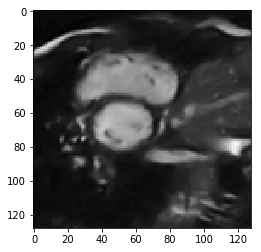

saving epoch {26}
Epoch: 27, Iteration: 1, Loss: 0.0009868110064417124, time: 2019-08-03 12:19:41.487245
Epoch: 27, Iteration: 101, Loss: 0.08837070653680712, time: 2019-08-03 12:21:39.200637
Epoch: 27, Iteration: 201, Loss: 0.16928401522454806, time: 2019-08-03 12:23:36.918220
Epoch: 27, Iteration: 301, Loss: 0.2548098019324243, time: 2019-08-03 12:25:35.520943
Epoch: 27, Iteration: 401, Loss: 0.33458512026118115, time: 2019-08-03 12:27:33.753799
Epoch: 27, Iteration: 501, Loss: 0.42303558575804345, time: 2019-08-03 12:29:31.371694
Epoch: 27, Iteration: 601, Loss: 0.5102902242506389, time: 2019-08-03 12:31:28.907155
Epoch: 27, Iteration: 701, Loss: 0.6048171396832913, time: 2019-08-03 12:33:26.489280
Epoch: 27, Iteration: 801, Loss: 0.6958751930797007, time: 2019-08-03 12:35:24.004593
Epoch: 27, Iteration: 901, Loss: 0.780311451817397, time: 2019-08-03 12:37:21.546758
Epoch: 27, Iteration: 1001, Loss: 0.8705324057955295, time: 2019-08-03 12:39:19.606277
Epoch: 27, Iteration: 1101, Los

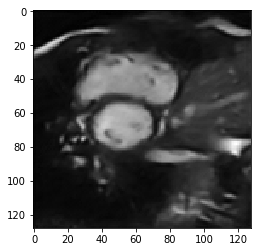

saving epoch {27}
Epoch: 28, Iteration: 1, Loss: 0.0006943733897060156, time: 2019-08-03 12:43:18.056692
Epoch: 28, Iteration: 101, Loss: 0.09026678709778935, time: 2019-08-03 12:45:15.988344
Epoch: 28, Iteration: 201, Loss: 0.182546850934159, time: 2019-08-03 12:47:15.652140
Epoch: 28, Iteration: 301, Loss: 0.2605991749005625, time: 2019-08-03 12:49:17.391675
Epoch: 28, Iteration: 401, Loss: 0.33258909375581425, time: 2019-08-03 12:51:18.517696
Epoch: 28, Iteration: 501, Loss: 0.4137906026589917, time: 2019-08-03 12:53:19.141528
Epoch: 28, Iteration: 601, Loss: 0.509739193614223, time: 2019-08-03 12:55:19.463486
Epoch: 28, Iteration: 701, Loss: 0.6020270713343052, time: 2019-08-03 12:57:20.478580
Epoch: 28, Iteration: 801, Loss: 0.6954612396220909, time: 2019-08-03 12:59:22.298961
Epoch: 28, Iteration: 901, Loss: 0.7784053443028824, time: 2019-08-03 13:01:23.271639
Epoch: 28, Iteration: 1001, Loss: 0.8589106320141582, time: 2019-08-03 13:03:24.867327
Epoch: 28, Iteration: 1101, Loss: 

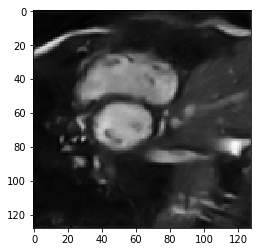

saving epoch {28}
Epoch: 29, Iteration: 1, Loss: 0.0008009033044800162, time: 2019-08-03 13:07:26.630076
Epoch: 29, Iteration: 101, Loss: 0.0785296693793498, time: 2019-08-03 13:09:26.164789
Epoch: 29, Iteration: 201, Loss: 0.1601765225350391, time: 2019-08-03 13:11:25.362820
Epoch: 29, Iteration: 301, Loss: 0.24759999438538216, time: 2019-08-03 13:13:25.158042
Epoch: 29, Iteration: 401, Loss: 0.33069632199476473, time: 2019-08-03 13:15:25.530268
Epoch: 29, Iteration: 501, Loss: 0.42064639850286767, time: 2019-08-03 13:17:24.931207
Epoch: 29, Iteration: 601, Loss: 0.5074269622273277, time: 2019-08-03 13:19:23.976729
Epoch: 29, Iteration: 701, Loss: 0.5967562995501794, time: 2019-08-03 13:21:22.723472
Epoch: 29, Iteration: 801, Loss: 0.6903315993840806, time: 2019-08-03 13:23:20.622571
Epoch: 29, Iteration: 901, Loss: 0.7705624419322703, time: 2019-08-03 13:25:18.203049
Epoch: 29, Iteration: 1001, Loss: 0.8499410132062621, time: 2019-08-03 13:27:15.701596
Epoch: 29, Iteration: 1101, Los

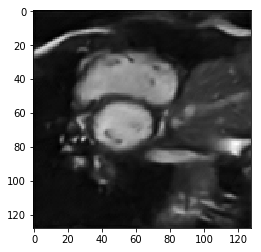

saving epoch {29}
Epoch: 30, Iteration: 1, Loss: 0.0009969265665858984, time: 2019-08-03 13:31:11.750395
Epoch: 30, Iteration: 101, Loss: 0.0823427262948826, time: 2019-08-03 13:33:09.212300
Epoch: 30, Iteration: 201, Loss: 0.16344308326370083, time: 2019-08-03 13:35:06.822672
Epoch: 30, Iteration: 301, Loss: 0.23950829432578757, time: 2019-08-03 13:37:04.305883
Epoch: 30, Iteration: 401, Loss: 0.321621305658482, time: 2019-08-03 13:39:01.785744
Epoch: 30, Iteration: 501, Loss: 0.4116614698723424, time: 2019-08-03 13:40:59.293550
Epoch: 30, Iteration: 601, Loss: 0.5026623664307408, time: 2019-08-03 13:42:56.655988
Epoch: 30, Iteration: 701, Loss: 0.5858071507245768, time: 2019-08-03 13:44:54.170493
Epoch: 30, Iteration: 801, Loss: 0.6705582077556755, time: 2019-08-03 13:46:51.632041
Epoch: 30, Iteration: 901, Loss: 0.758068423892837, time: 2019-08-03 13:48:49.041599
Epoch: 30, Iteration: 1001, Loss: 0.8405805389920715, time: 2019-08-03 13:50:46.503011
Epoch: 30, Iteration: 1101, Loss: 

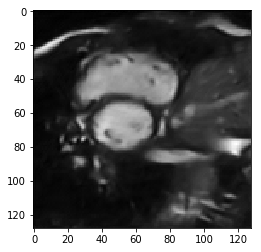

saving epoch {30}
Epoch: 31, Iteration: 1, Loss: 0.0005219945451244712, time: 2019-08-03 13:54:42.148490
Epoch: 31, Iteration: 101, Loss: 0.09313066944014281, time: 2019-08-03 13:56:39.563022
Epoch: 31, Iteration: 201, Loss: 0.1687540007987991, time: 2019-08-03 13:58:36.991924
Epoch: 31, Iteration: 301, Loss: 0.24028284076484852, time: 2019-08-03 14:00:34.429933
Epoch: 31, Iteration: 401, Loss: 0.3168932206754107, time: 2019-08-03 14:02:31.857996
Epoch: 31, Iteration: 501, Loss: 0.39906037057517096, time: 2019-08-03 14:04:29.357423
Epoch: 31, Iteration: 601, Loss: 0.4742677086906042, time: 2019-08-03 14:06:26.793816
Epoch: 31, Iteration: 701, Loss: 0.5570041347818915, time: 2019-08-03 14:08:24.288933
Epoch: 31, Iteration: 801, Loss: 0.6391306830628309, time: 2019-08-03 14:10:21.776684
Epoch: 31, Iteration: 901, Loss: 0.7280363482714165, time: 2019-08-03 14:12:19.290648
Epoch: 31, Iteration: 1001, Loss: 0.8169744572369382, time: 2019-08-03 14:14:16.772817
Epoch: 31, Iteration: 1101, Los

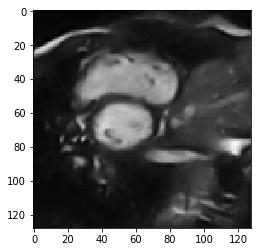

saving epoch {31}
Epoch: 32, Iteration: 1, Loss: 0.0010945311514660716, time: 2019-08-03 14:18:12.612154
Epoch: 32, Iteration: 101, Loss: 0.07794272064347751, time: 2019-08-03 14:20:10.181636
Epoch: 32, Iteration: 201, Loss: 0.1549960759584792, time: 2019-08-03 14:22:07.607220
Epoch: 32, Iteration: 301, Loss: 0.23362489949795417, time: 2019-08-03 14:24:05.082188
Epoch: 32, Iteration: 401, Loss: 0.31915583030786365, time: 2019-08-03 14:26:02.496119
Epoch: 32, Iteration: 501, Loss: 0.405453394894721, time: 2019-08-03 14:27:59.971652
Epoch: 32, Iteration: 601, Loss: 0.4825770108582219, time: 2019-08-03 14:29:57.374350
Epoch: 32, Iteration: 701, Loss: 0.5711709350143792, time: 2019-08-03 14:31:54.809845
Epoch: 32, Iteration: 801, Loss: 0.6540830742014805, time: 2019-08-03 14:33:52.224281
Epoch: 32, Iteration: 901, Loss: 0.7343547991622472, time: 2019-08-03 14:35:49.602831
Epoch: 32, Iteration: 1001, Loss: 0.8146367596491473, time: 2019-08-03 14:37:47.042969
Epoch: 32, Iteration: 1101, Loss

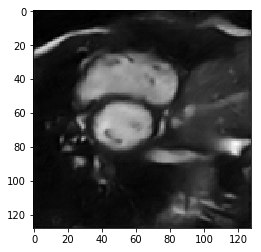

saving epoch {32}
Epoch: 33, Iteration: 1, Loss: 0.000675744260661304, time: 2019-08-03 14:41:42.705955
Epoch: 33, Iteration: 101, Loss: 0.08517314604250714, time: 2019-08-03 14:43:40.142462
Epoch: 33, Iteration: 201, Loss: 0.16490159003296867, time: 2019-08-03 14:45:37.529431
Epoch: 33, Iteration: 301, Loss: 0.2358381124213338, time: 2019-08-03 14:47:34.986534
Epoch: 33, Iteration: 401, Loss: 0.31854947441024706, time: 2019-08-03 14:49:32.433355
Epoch: 33, Iteration: 501, Loss: 0.39430457665002905, time: 2019-08-03 14:51:29.876856
Epoch: 33, Iteration: 601, Loss: 0.4727502189343795, time: 2019-08-03 14:53:27.334413
Epoch: 33, Iteration: 701, Loss: 0.565484898048453, time: 2019-08-03 14:55:24.695935
Epoch: 33, Iteration: 801, Loss: 0.6502583133406006, time: 2019-08-03 14:57:22.184017
Epoch: 33, Iteration: 901, Loss: 0.7232455088815186, time: 2019-08-03 14:59:19.689824
Epoch: 33, Iteration: 1001, Loss: 0.7993712356837932, time: 2019-08-03 15:01:17.044418
Epoch: 33, Iteration: 1101, Loss

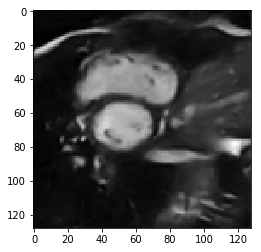

saving epoch {33}
Epoch: 34, Iteration: 1, Loss: 0.0006598393083550036, time: 2019-08-03 15:05:12.992693
Epoch: 34, Iteration: 101, Loss: 0.08006144591490738, time: 2019-08-03 15:07:10.245885
Epoch: 34, Iteration: 201, Loss: 0.1623245492519345, time: 2019-08-03 15:09:07.663077
Epoch: 34, Iteration: 301, Loss: 0.2423193301365245, time: 2019-08-03 15:11:04.942996
Epoch: 34, Iteration: 401, Loss: 0.3261229535273742, time: 2019-08-03 15:13:02.178398
Epoch: 34, Iteration: 501, Loss: 0.3996999840310309, time: 2019-08-03 15:14:59.463814
Epoch: 34, Iteration: 601, Loss: 0.4747100745153148, time: 2019-08-03 15:16:56.714053
Epoch: 34, Iteration: 801, Loss: 0.625844042020617, time: 2019-08-03 15:20:51.291966
Epoch: 34, Iteration: 901, Loss: 0.6992090753046796, time: 2019-08-03 15:22:48.508478
Epoch: 34, Iteration: 1001, Loss: 0.781382575398311, time: 2019-08-03 15:24:45.887361
Epoch: 34, Iteration: 1101, Loss: 0.8699873326695524, time: 2019-08-03 15:26:43.168733
Epoch: 35, Iteration: 101, Loss: 0

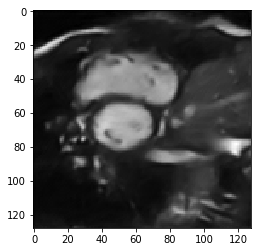

saving epoch {35}
Epoch: 36, Iteration: 1, Loss: 0.0005368714919313788, time: 2019-08-03 15:52:09.663344
Epoch: 36, Iteration: 101, Loss: 0.07577021393808536, time: 2019-08-03 15:54:06.888622
Epoch: 36, Iteration: 201, Loss: 0.14834136801073328, time: 2019-08-03 15:56:04.161916
Epoch: 36, Iteration: 301, Loss: 0.2235363042127574, time: 2019-08-03 15:58:01.424934
Epoch: 36, Iteration: 401, Loss: 0.30251677222258877, time: 2019-08-03 15:59:58.765813
Epoch: 36, Iteration: 501, Loss: 0.37647840405406896, time: 2019-08-03 16:01:56.084184
Epoch: 36, Iteration: 601, Loss: 0.4545551535120467, time: 2019-08-03 16:03:53.312447
Epoch: 36, Iteration: 701, Loss: 0.53644386351516, time: 2019-08-03 16:05:50.648863
Epoch: 36, Iteration: 801, Loss: 0.6151407452562125, time: 2019-08-03 16:07:47.912725
Epoch: 36, Iteration: 901, Loss: 0.6911374794290168, time: 2019-08-03 16:09:45.183788
Epoch: 36, Iteration: 1001, Loss: 0.7607498901052168, time: 2019-08-03 16:11:42.488316
Epoch: 36, Iteration: 1101, Loss

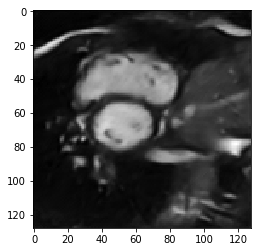

saving epoch {36}
Epoch: 37, Iteration: 1, Loss: 0.000652243965305388, time: 2019-08-03 16:15:37.914688
Epoch: 37, Iteration: 101, Loss: 0.07496893961797468, time: 2019-08-03 16:17:35.336032
Epoch: 37, Iteration: 201, Loss: 0.1449610941344872, time: 2019-08-03 16:19:32.675585
Epoch: 37, Iteration: 301, Loss: 0.22429248373373412, time: 2019-08-03 16:21:30.119255
Epoch: 37, Iteration: 401, Loss: 0.3048892005754169, time: 2019-08-03 16:23:30.560178
Epoch: 37, Iteration: 501, Loss: 0.3815864706411958, time: 2019-08-03 16:25:31.755538
Epoch: 37, Iteration: 601, Loss: 0.47045324149075896, time: 2019-08-03 16:27:33.230242
Epoch: 37, Iteration: 701, Loss: 0.5461271926469635, time: 2019-08-03 16:29:35.652529
Epoch: 37, Iteration: 801, Loss: 0.6214573866163846, time: 2019-08-03 16:31:37.647697
Epoch: 37, Iteration: 901, Loss: 0.6891180540551431, time: 2019-08-03 16:33:39.074559
Epoch: 37, Iteration: 1001, Loss: 0.7662855699891225, time: 2019-08-03 16:35:40.836573
Epoch: 37, Iteration: 1101, Loss

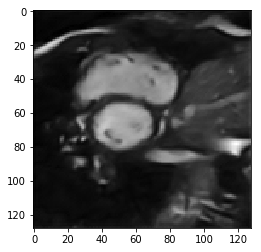

saving epoch {37}
Epoch: 38, Iteration: 1, Loss: 0.0008399737998843193, time: 2019-08-03 16:39:45.264814
Epoch: 38, Iteration: 101, Loss: 0.0843735438247677, time: 2019-08-03 16:41:46.909518
Epoch: 38, Iteration: 201, Loss: 0.15719037869712338, time: 2019-08-03 16:43:48.525808
Epoch: 38, Iteration: 301, Loss: 0.23648334122844972, time: 2019-08-03 16:45:50.836643
Epoch: 38, Iteration: 401, Loss: 0.32670296091237105, time: 2019-08-03 16:47:53.540597
Epoch: 38, Iteration: 501, Loss: 0.40059070935240015, time: 2019-08-03 16:49:54.516338
Epoch: 38, Iteration: 601, Loss: 0.4734496464225231, time: 2019-08-03 16:51:55.374976
Epoch: 38, Iteration: 701, Loss: 0.545114353459212, time: 2019-08-03 16:53:54.543433
Epoch: 38, Iteration: 801, Loss: 0.6231563743640436, time: 2019-08-03 16:55:53.047708
Epoch: 38, Iteration: 901, Loss: 0.7025293111073552, time: 2019-08-03 16:57:52.368231
Epoch: 38, Iteration: 1001, Loss: 0.7721326509927167, time: 2019-08-03 16:59:51.983819
Epoch: 38, Iteration: 1101, Los

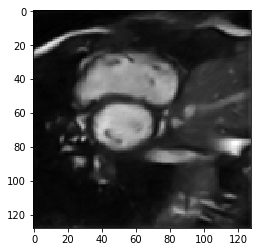

saving epoch {38}
Epoch: 39, Iteration: 1, Loss: 0.0007623211131431162, time: 2019-08-03 17:03:52.412844
Epoch: 39, Iteration: 101, Loss: 0.07670271408278495, time: 2019-08-03 17:05:50.534165
Epoch: 39, Iteration: 201, Loss: 0.14157326667918824, time: 2019-08-03 17:07:48.625226
Epoch: 39, Iteration: 301, Loss: 0.2211531297361944, time: 2019-08-03 17:09:46.489650
Epoch: 39, Iteration: 401, Loss: 0.29344176544691436, time: 2019-08-03 17:11:44.044245
Epoch: 39, Iteration: 501, Loss: 0.35968284457339905, time: 2019-08-03 17:13:41.623553
Epoch: 39, Iteration: 601, Loss: 0.43520996189909056, time: 2019-08-03 17:15:39.055542
Epoch: 39, Iteration: 701, Loss: 0.5102076083130669, time: 2019-08-03 17:17:36.518209
Epoch: 39, Iteration: 801, Loss: 0.5997413717850577, time: 2019-08-03 17:19:34.134080
Epoch: 39, Iteration: 901, Loss: 0.6818378471652977, time: 2019-08-03 17:21:31.603819
Epoch: 39, Iteration: 1001, Loss: 0.7517799743218347, time: 2019-08-03 17:23:29.039465
Epoch: 39, Iteration: 1101, L

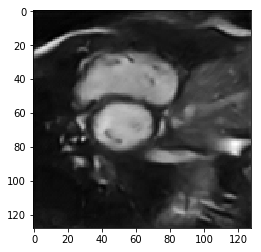

saving epoch {39}
Epoch: 40, Iteration: 1, Loss: 0.0009668778511695564, time: 2019-08-03 17:27:26.853098
Epoch: 40, Iteration: 101, Loss: 0.07209998802863993, time: 2019-08-03 17:29:28.358167
Epoch: 40, Iteration: 201, Loss: 0.14101494633359835, time: 2019-08-03 17:31:29.459754
Epoch: 40, Iteration: 301, Loss: 0.21931801721802913, time: 2019-08-03 17:33:31.294432
Epoch: 40, Iteration: 401, Loss: 0.2880788999318611, time: 2019-08-03 17:35:34.239005
Epoch: 40, Iteration: 501, Loss: 0.35960035026073456, time: 2019-08-03 17:37:36.407380
Epoch: 40, Iteration: 601, Loss: 0.4265317147219321, time: 2019-08-03 17:39:36.659789
Epoch: 40, Iteration: 701, Loss: 0.5039317743066931, time: 2019-08-03 17:41:37.120822
Epoch: 40, Iteration: 801, Loss: 0.579702384347911, time: 2019-08-03 17:43:36.599084
Epoch: 40, Iteration: 901, Loss: 0.6481733101099962, time: 2019-08-03 17:45:37.339578
Epoch: 40, Iteration: 1001, Loss: 0.7194317799148848, time: 2019-08-03 17:47:38.555886
Epoch: 40, Iteration: 1101, Los

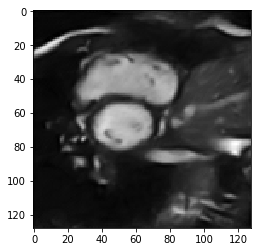

saving epoch {40}
Epoch: 41, Iteration: 1, Loss: 0.000744426972232759, time: 2019-08-03 17:51:42.677921
Epoch: 41, Iteration: 101, Loss: 0.07468286296352744, time: 2019-08-03 17:53:45.048550
Epoch: 41, Iteration: 201, Loss: 0.1421753102913499, time: 2019-08-03 17:55:46.501169
Epoch: 41, Iteration: 301, Loss: 0.2132895795512013, time: 2019-08-03 17:57:48.788221
Epoch: 41, Iteration: 401, Loss: 0.29829341039294377, time: 2019-08-03 17:59:50.944627
Epoch: 41, Iteration: 501, Loss: 0.3665551457670517, time: 2019-08-03 18:01:52.817103
Epoch: 41, Iteration: 601, Loss: 0.4421282213588711, time: 2019-08-03 18:03:54.806702
Epoch: 41, Iteration: 701, Loss: 0.5134033915237524, time: 2019-08-03 18:05:56.753746
Epoch: 41, Iteration: 801, Loss: 0.581530193798244, time: 2019-08-03 18:07:57.958195
Epoch: 41, Iteration: 901, Loss: 0.6509150208439678, time: 2019-08-03 18:09:58.846979
Epoch: 41, Iteration: 1001, Loss: 0.7330565858865157, time: 2019-08-03 18:12:00.576018
Epoch: 41, Iteration: 1101, Loss: 

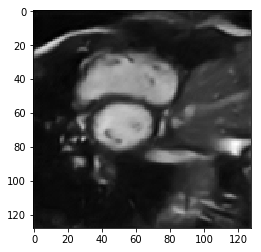

saving epoch {41}
Epoch: 42, Iteration: 1, Loss: 0.0008932510390877724, time: 2019-08-03 18:16:06.254161
Epoch: 42, Iteration: 101, Loss: 0.0854407612932846, time: 2019-08-03 18:18:08.088338
Epoch: 42, Iteration: 201, Loss: 0.1572647939028684, time: 2019-08-03 18:20:09.655495
Epoch: 42, Iteration: 301, Loss: 0.21980503146187402, time: 2019-08-03 18:22:11.045787
Epoch: 42, Iteration: 401, Loss: 0.2885972147632856, time: 2019-08-03 18:24:12.855181
Epoch: 42, Iteration: 501, Loss: 0.3640144183591474, time: 2019-08-03 18:26:13.446786
Epoch: 42, Iteration: 601, Loss: 0.43770357861649245, time: 2019-08-03 18:28:12.897782
Epoch: 42, Iteration: 701, Loss: 0.51102739336784, time: 2019-08-03 18:30:11.422677
Epoch: 42, Iteration: 801, Loss: 0.5818159614864271, time: 2019-08-03 18:32:09.421328
Epoch: 42, Iteration: 901, Loss: 0.6534461463161279, time: 2019-08-03 18:34:07.148728
Epoch: 42, Iteration: 1001, Loss: 0.7270075480046216, time: 2019-08-03 18:36:04.688384
Epoch: 42, Iteration: 1101, Loss: 

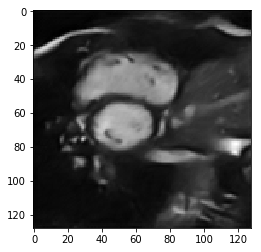

saving epoch {42}
Epoch: 43, Iteration: 1, Loss: 0.001728908740915358, time: 2019-08-03 18:40:03.326839
Epoch: 43, Iteration: 101, Loss: 0.07600535021629184, time: 2019-08-03 18:42:00.922358
Epoch: 43, Iteration: 201, Loss: 0.1489758615498431, time: 2019-08-03 18:43:58.373467
Epoch: 43, Iteration: 301, Loss: 0.21879245922900736, time: 2019-08-03 18:45:57.158294
Epoch: 43, Iteration: 401, Loss: 0.28750906538334675, time: 2019-08-03 18:47:58.123709
Epoch: 43, Iteration: 501, Loss: 0.3649801927385852, time: 2019-08-03 18:49:59.192103
Epoch: 43, Iteration: 601, Loss: 0.4343775723100407, time: 2019-08-03 18:52:00.438992
Epoch: 43, Iteration: 701, Loss: 0.5069049198209541, time: 2019-08-03 18:54:03.466275
Epoch: 43, Iteration: 801, Loss: 0.5792353510478279, time: 2019-08-03 18:56:05.888446
Epoch: 43, Iteration: 901, Loss: 0.6528012793714879, time: 2019-08-03 18:58:07.465579
Epoch: 43, Iteration: 1001, Loss: 0.7185615604248596, time: 2019-08-03 19:00:08.003180
Epoch: 43, Iteration: 1101, Loss

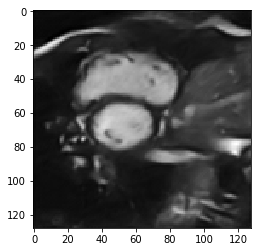

saving epoch {43}
Epoch: 44, Iteration: 1, Loss: 0.00047256643301807344, time: 2019-08-03 19:04:12.909037
Epoch: 44, Iteration: 101, Loss: 0.06333817195263691, time: 2019-08-03 19:06:14.654646
Epoch: 44, Iteration: 201, Loss: 0.1324632194591686, time: 2019-08-03 19:08:15.267765
Epoch: 44, Iteration: 301, Loss: 0.20368841575691476, time: 2019-08-03 19:10:16.153145
Epoch: 44, Iteration: 401, Loss: 0.27190613841230515, time: 2019-08-03 19:12:17.840633
Epoch: 44, Iteration: 501, Loss: 0.34737500951450784, time: 2019-08-03 19:14:17.214564
Epoch: 44, Iteration: 601, Loss: 0.42067120964929927, time: 2019-08-03 19:16:17.262842
Epoch: 44, Iteration: 701, Loss: 0.4982715051883133, time: 2019-08-03 19:18:18.434049
Epoch: 44, Iteration: 801, Loss: 0.5667824311094591, time: 2019-08-03 19:20:19.465039
Epoch: 44, Iteration: 901, Loss: 0.631385647910065, time: 2019-08-03 19:22:20.929487
Epoch: 44, Iteration: 1001, Loss: 0.7021647187502822, time: 2019-08-03 19:24:22.299078
Epoch: 44, Iteration: 1101, L

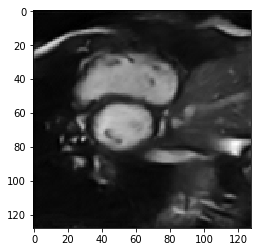

saving epoch {44}
Epoch: 45, Iteration: 1, Loss: 0.0006726583233103156, time: 2019-08-03 19:28:26.027428
Epoch: 45, Iteration: 101, Loss: 0.08112333086319268, time: 2019-08-03 19:30:26.424636
Epoch: 45, Iteration: 201, Loss: 0.15048389742150903, time: 2019-08-03 19:32:26.991668
Epoch: 45, Iteration: 301, Loss: 0.22275734422146343, time: 2019-08-03 19:34:26.448686
Epoch: 45, Iteration: 401, Loss: 0.29133697297947947, time: 2019-08-03 19:36:25.582869
Epoch: 45, Iteration: 501, Loss: 0.3599913669313537, time: 2019-08-03 19:38:25.059033
Epoch: 45, Iteration: 601, Loss: 0.42969387900666334, time: 2019-08-03 19:40:24.443273
Epoch: 45, Iteration: 701, Loss: 0.5082401230756659, time: 2019-08-03 19:42:24.105072
Epoch: 45, Iteration: 801, Loss: 0.5741532291285694, time: 2019-08-03 19:44:24.265426
Epoch: 45, Iteration: 901, Loss: 0.6393875135545386, time: 2019-08-03 19:46:25.207479
Epoch: 45, Iteration: 1001, Loss: 0.7113142456364585, time: 2019-08-03 19:48:25.996730
Epoch: 45, Iteration: 1101, L

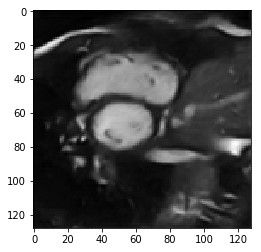

saving epoch {45}
Epoch: 46, Iteration: 1, Loss: 0.0007619985844939947, time: 2019-08-03 19:52:28.609550
Epoch: 46, Iteration: 101, Loss: 0.06739427734282799, time: 2019-08-03 19:54:30.713518
Epoch: 46, Iteration: 201, Loss: 0.13627326114510652, time: 2019-08-03 19:56:32.929597
Epoch: 46, Iteration: 301, Loss: 0.2094215121178422, time: 2019-08-03 19:58:32.897664
Epoch: 46, Iteration: 401, Loss: 0.2811920373351313, time: 2019-08-03 20:00:33.950210
Epoch: 46, Iteration: 501, Loss: 0.3579553378804121, time: 2019-08-03 20:02:33.327225
Epoch: 46, Iteration: 601, Loss: 0.4284525726689026, time: 2019-08-03 20:04:32.433278
Epoch: 46, Iteration: 701, Loss: 0.5060120371636003, time: 2019-08-03 20:06:30.799569
Epoch: 46, Iteration: 801, Loss: 0.5862885558744892, time: 2019-08-03 20:08:28.748840
Epoch: 46, Iteration: 901, Loss: 0.6576210357889067, time: 2019-08-03 20:10:26.753836
Epoch: 46, Iteration: 1001, Loss: 0.7252555657469202, time: 2019-08-03 20:12:24.402098
Epoch: 46, Iteration: 1101, Loss

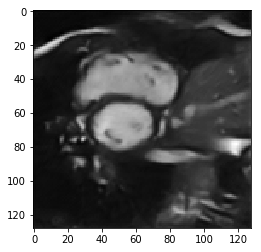

saving epoch {46}
Epoch: 47, Iteration: 1, Loss: 0.0012193789007142186, time: 2019-08-03 20:16:20.428459
Epoch: 47, Iteration: 101, Loss: 0.06721369767910801, time: 2019-08-03 20:18:17.933662
Epoch: 47, Iteration: 201, Loss: 0.13243503708508797, time: 2019-08-03 20:20:15.494811
Epoch: 47, Iteration: 301, Loss: 0.20264306257013232, time: 2019-08-03 20:22:12.974058
Epoch: 47, Iteration: 401, Loss: 0.2738589830696583, time: 2019-08-03 20:24:10.506782
Epoch: 47, Iteration: 501, Loss: 0.345525027543772, time: 2019-08-03 20:26:07.994218
Epoch: 47, Iteration: 601, Loss: 0.4176050845126156, time: 2019-08-03 20:28:05.460743
Epoch: 47, Iteration: 701, Loss: 0.4892682498320937, time: 2019-08-03 20:30:02.888365
Epoch: 47, Iteration: 801, Loss: 0.5620180460100528, time: 2019-08-03 20:32:00.311439
Epoch: 47, Iteration: 901, Loss: 0.6327625415869989, time: 2019-08-03 20:33:57.917609
Epoch: 47, Iteration: 1001, Loss: 0.7007769925985485, time: 2019-08-03 20:35:58.884665
Epoch: 47, Iteration: 1101, Loss

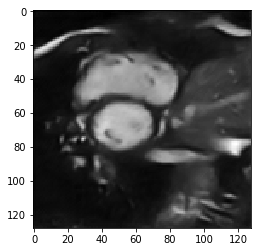

saving epoch {47}
Epoch: 48, Iteration: 1, Loss: 0.0003830883069895208, time: 2019-08-03 20:40:01.990823
Epoch: 48, Iteration: 101, Loss: 0.06804552939138375, time: 2019-08-03 20:42:03.734505
Epoch: 48, Iteration: 201, Loss: 0.14187983953161165, time: 2019-08-03 20:44:05.883866
Epoch: 48, Iteration: 301, Loss: 0.20768424100242555, time: 2019-08-03 20:46:06.163386
Epoch: 48, Iteration: 401, Loss: 0.27165649173548445, time: 2019-08-03 20:48:06.982774
Epoch: 48, Iteration: 501, Loss: 0.3390349948022049, time: 2019-08-03 20:50:09.871242
Epoch: 48, Iteration: 601, Loss: 0.40023514797212556, time: 2019-08-03 20:52:11.130454
Epoch: 48, Iteration: 701, Loss: 0.47663642157567665, time: 2019-08-03 20:54:12.318614
Epoch: 48, Iteration: 801, Loss: 0.548371229931945, time: 2019-08-03 20:56:13.790446
Epoch: 48, Iteration: 901, Loss: 0.6202479066269007, time: 2019-08-03 20:58:15.055111
Epoch: 48, Iteration: 1001, Loss: 0.6934293559752405, time: 2019-08-03 21:00:16.609729
Epoch: 48, Iteration: 1101, L

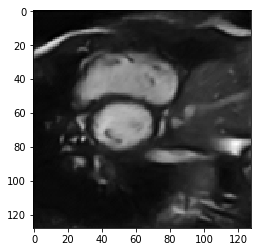

saving epoch {48}
Epoch: 49, Iteration: 1, Loss: 0.0009389913757331669, time: 2019-08-03 21:04:22.236236
Epoch: 49, Iteration: 101, Loss: 0.06616308592492715, time: 2019-08-03 21:06:24.379980
Epoch: 49, Iteration: 201, Loss: 0.13006167848652694, time: 2019-08-03 21:08:25.854493
Epoch: 49, Iteration: 301, Loss: 0.19240557863668073, time: 2019-08-03 21:10:27.245551
Epoch: 49, Iteration: 401, Loss: 0.25558195156918373, time: 2019-08-03 21:12:28.304407
Epoch: 49, Iteration: 501, Loss: 0.32413775294844527, time: 2019-08-03 21:14:28.763961
Epoch: 49, Iteration: 601, Loss: 0.3880572930793278, time: 2019-08-03 21:16:27.679610
Epoch: 49, Iteration: 701, Loss: 0.452444414870115, time: 2019-08-03 21:18:25.651853
Epoch: 49, Iteration: 801, Loss: 0.531562969321385, time: 2019-08-03 21:20:23.354910
Epoch: 49, Iteration: 901, Loss: 0.6177672883786727, time: 2019-08-03 21:22:20.961204
Epoch: 49, Iteration: 1001, Loss: 0.6974235629022587, time: 2019-08-03 21:24:18.510942
Epoch: 49, Iteration: 1101, Los

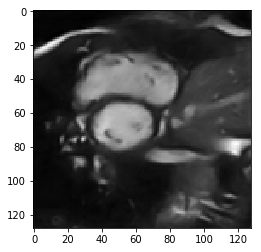

saving epoch {49}
Epoch: 50, Iteration: 1, Loss: 0.000872424803674221, time: 2019-08-03 21:28:14.476733
Epoch: 50, Iteration: 101, Loss: 0.07017224171431735, time: 2019-08-03 21:30:11.750450
Epoch: 50, Iteration: 201, Loss: 0.1359857872739667, time: 2019-08-03 21:32:08.979606
Epoch: 50, Iteration: 301, Loss: 0.20013994279725011, time: 2019-08-03 21:34:06.282396
Epoch: 50, Iteration: 401, Loss: 0.263286692861584, time: 2019-08-03 21:36:03.513691
Epoch: 50, Iteration: 501, Loss: 0.3322146440477809, time: 2019-08-03 21:38:00.834898
Epoch: 50, Iteration: 601, Loss: 0.400211654312443, time: 2019-08-03 21:39:58.098424
Epoch: 50, Iteration: 701, Loss: 0.4829230440373067, time: 2019-08-03 21:41:55.291453
Epoch: 50, Iteration: 801, Loss: 0.5611245080654044, time: 2019-08-03 21:43:52.528960
Epoch: 50, Iteration: 901, Loss: 0.6341936191893183, time: 2019-08-03 21:45:49.720959
Epoch: 50, Iteration: 1001, Loss: 0.7086496171395993, time: 2019-08-03 21:47:46.911545
Epoch: 50, Iteration: 1101, Loss: 0

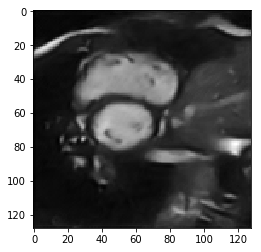

saving epoch {50}
Epoch: 51, Iteration: 1, Loss: 0.0006258657667785883, time: 2019-08-03 21:51:42.273546
Epoch: 51, Iteration: 101, Loss: 0.07355880743125454, time: 2019-08-03 21:53:39.565850
Epoch: 51, Iteration: 201, Loss: 0.13971723671420477, time: 2019-08-03 21:55:36.770030
Epoch: 51, Iteration: 301, Loss: 0.20467125115101226, time: 2019-08-03 21:57:33.990008
Epoch: 51, Iteration: 401, Loss: 0.2727401159936562, time: 2019-08-03 21:59:31.216590
Epoch: 51, Iteration: 501, Loss: 0.33853797026677057, time: 2019-08-03 22:01:28.438817
Epoch: 51, Iteration: 601, Loss: 0.39927520090714097, time: 2019-08-03 22:03:25.610762
Epoch: 51, Iteration: 701, Loss: 0.4738021064840723, time: 2019-08-03 22:05:22.794642
Epoch: 51, Iteration: 801, Loss: 0.5490523761545774, time: 2019-08-03 22:07:20.028131
Epoch: 51, Iteration: 901, Loss: 0.6167652059230022, time: 2019-08-03 22:09:17.249292
Epoch: 51, Iteration: 1001, Loss: 0.6853343855764251, time: 2019-08-03 22:11:14.470617
Epoch: 51, Iteration: 1101, L

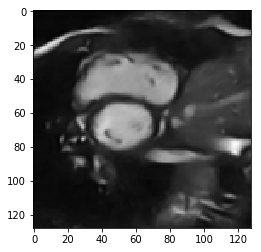

saving epoch {51}
Epoch: 52, Iteration: 1, Loss: 0.0007635258371010423, time: 2019-08-03 22:15:09.856378
Epoch: 52, Iteration: 101, Loss: 0.06675078111584298, time: 2019-08-03 22:17:07.072286
Epoch: 52, Iteration: 201, Loss: 0.13584737820201553, time: 2019-08-03 22:19:04.298643
Epoch: 52, Iteration: 301, Loss: 0.19983997833332978, time: 2019-08-03 22:21:01.535922
Epoch: 52, Iteration: 401, Loss: 0.2801222745911218, time: 2019-08-03 22:22:58.711512
Epoch: 52, Iteration: 501, Loss: 0.3494372501008911, time: 2019-08-03 22:24:55.948648
Epoch: 52, Iteration: 601, Loss: 0.41420747523079626, time: 2019-08-03 22:26:53.189732
Epoch: 52, Iteration: 701, Loss: 0.4888606680033263, time: 2019-08-03 22:28:50.375764
Epoch: 52, Iteration: 801, Loss: 0.5556152006902266, time: 2019-08-03 22:30:47.557141
Epoch: 52, Iteration: 901, Loss: 0.6239301375753712, time: 2019-08-03 22:32:44.747896
Epoch: 52, Iteration: 1001, Loss: 0.6939130235696211, time: 2019-08-03 22:34:42.015786
Epoch: 52, Iteration: 1101, Lo

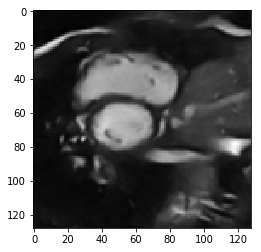

saving epoch {52}
Epoch: 53, Iteration: 1, Loss: 0.0005281601333990693, time: 2019-08-03 22:38:37.311362
Epoch: 53, Iteration: 101, Loss: 0.058117938388022594, time: 2019-08-03 22:40:34.638347
Epoch: 53, Iteration: 201, Loss: 0.1272646684810752, time: 2019-08-03 22:42:31.877123
Epoch: 53, Iteration: 301, Loss: 0.20120645576389506, time: 2019-08-03 22:44:29.089486
Epoch: 53, Iteration: 401, Loss: 0.268464399385266, time: 2019-08-03 22:46:26.269062
Epoch: 53, Iteration: 501, Loss: 0.33752534419181757, time: 2019-08-03 22:48:23.565670
Epoch: 53, Iteration: 601, Loss: 0.39623252520686947, time: 2019-08-03 22:50:20.847357
Epoch: 53, Iteration: 701, Loss: 0.4663227599230595, time: 2019-08-03 22:52:18.108983
Epoch: 53, Iteration: 801, Loss: 0.5368700637918664, time: 2019-08-03 22:54:15.254234
Epoch: 53, Iteration: 901, Loss: 0.60504931032483, time: 2019-08-03 22:56:12.524981
Epoch: 53, Iteration: 1001, Loss: 0.6717866244289326, time: 2019-08-03 22:58:09.789377
Epoch: 53, Iteration: 1101, Loss

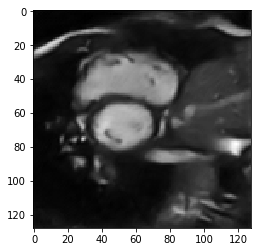

saving epoch {53}
Epoch: 54, Iteration: 1, Loss: 0.000756572640966624, time: 2019-08-03 23:02:05.099498
Epoch: 54, Iteration: 101, Loss: 0.08096160384593531, time: 2019-08-03 23:04:02.297567
Epoch: 54, Iteration: 201, Loss: 0.1587797250249423, time: 2019-08-03 23:05:59.534787
Epoch: 54, Iteration: 301, Loss: 0.22578958130907267, time: 2019-08-03 23:07:56.716719
Epoch: 54, Iteration: 401, Loss: 0.29442071937955916, time: 2019-08-03 23:09:53.892673
Epoch: 54, Iteration: 501, Loss: 0.36032343612168916, time: 2019-08-03 23:11:52.008080
Epoch: 54, Iteration: 601, Loss: 0.42881377719459124, time: 2019-08-03 23:13:52.483110
Epoch: 54, Iteration: 701, Loss: 0.4965160498104524, time: 2019-08-03 23:15:53.741068
Epoch: 54, Iteration: 801, Loss: 0.5613041116594104, time: 2019-08-03 23:17:55.066398
Epoch: 54, Iteration: 901, Loss: 0.6288143124693306, time: 2019-08-03 23:19:56.487621
Epoch: 54, Iteration: 1001, Loss: 0.7030631476518465, time: 2019-08-03 23:21:58.619684
Epoch: 54, Iteration: 1101, Lo

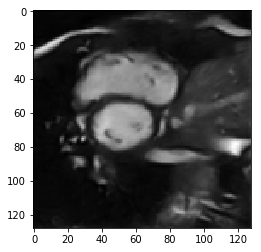

saving epoch {54}
Epoch: 55, Iteration: 1, Loss: 0.0005246122600510716, time: 2019-08-03 23:26:02.084520
Epoch: 55, Iteration: 101, Loss: 0.07133647071896121, time: 2019-08-03 23:28:03.070947
Epoch: 55, Iteration: 201, Loss: 0.13528616176336072, time: 2019-08-03 23:30:03.259938
Epoch: 55, Iteration: 301, Loss: 0.1963244576472789, time: 2019-08-03 23:32:03.512243
Epoch: 55, Iteration: 401, Loss: 0.2597293330472894, time: 2019-08-03 23:34:04.002346
Epoch: 55, Iteration: 501, Loss: 0.32350035189301707, time: 2019-08-03 23:36:03.983695
Epoch: 55, Iteration: 601, Loss: 0.40291754115605727, time: 2019-08-03 23:38:03.773031
Epoch: 55, Iteration: 701, Loss: 0.46941998254624195, time: 2019-08-03 23:40:02.559624
Epoch: 55, Iteration: 801, Loss: 0.5393796327989548, time: 2019-08-03 23:42:00.686889


In [ ]:
training_loop(100, optimizer, model, loss_fn, train_loader)

My internet got disconnected.
Had to continute using the last state

In [44]:
import os
def load_checkpoint(model, optimizer, filename='ckp_crnn_20und_epoch_54.pth'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        #start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        #losslogger = checkpoint['losslogger']
        #print("=> loaded checkpoint '{}' (epoch {})"
                  #.format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer
model, optimizer = load_checkpoint(model, optimizer)

=> loading checkpoint 'ckp_crnn_20und_epoch_54.pth'


In [47]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_crnn_13und_epoch__%d.pth'%54)
    for epoch in range(55, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels, k, m in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            k = k.to(device)
            m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs, k, m)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point, k_point, mask_point, mode=True)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(np.sqrt(prediction[0,0,:,:,0]**2 + prediction[0,1,:,:,0]**2), cmap='gray')
        plt.show()
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_crnn_13und_epoch_%d.pth'%epoch)

saving epoch {0}


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNN_MRI. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type BCRNNlayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CRNNcell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DataConsistencyInKspace. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be c

Epoch: 55, Iteration: 1, Loss: 0.0007176984800025821, time: 2019-08-04 07:00:43.643605
Epoch: 55, Iteration: 101, Loss: 0.07072767059435137, time: 2019-08-04 07:02:41.768736
Epoch: 55, Iteration: 201, Loss: 0.13371463911607862, time: 2019-08-04 07:04:39.456446
Epoch: 55, Iteration: 301, Loss: 0.19676284048182424, time: 2019-08-04 07:06:37.133214
Epoch: 55, Iteration: 401, Loss: 0.2640064704028191, time: 2019-08-04 07:08:35.849360
Epoch: 55, Iteration: 501, Loss: 0.32624364577350207, time: 2019-08-04 07:10:33.923076
Epoch: 55, Iteration: 601, Loss: 0.394891493342584, time: 2019-08-04 07:12:31.702246
Epoch: 55, Iteration: 701, Loss: 0.4586942988098599, time: 2019-08-04 07:14:29.059638
Epoch: 55, Iteration: 801, Loss: 0.5253688127850182, time: 2019-08-04 07:16:26.317116
Epoch: 55, Iteration: 901, Loss: 0.6000929406436626, time: 2019-08-04 07:18:23.658685
Epoch: 55, Iteration: 1001, Loss: 0.6663113236136269, time: 2019-08-04 07:20:20.769145
Epoch: 55, Iteration: 1101, Loss: 0.7281945974245

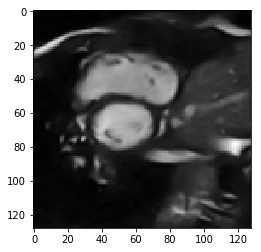

saving epoch {55}
Epoch: 56, Iteration: 1, Loss: 0.00042670179391279817, time: 2019-08-04 07:24:19.171124
Epoch: 56, Iteration: 101, Loss: 0.06767796791973524, time: 2019-08-04 07:26:20.002356
Epoch: 56, Iteration: 201, Loss: 0.1258656454301672, time: 2019-08-04 07:28:21.091436
Epoch: 56, Iteration: 301, Loss: 0.1894379068253329, time: 2019-08-04 07:30:22.705988
Epoch: 56, Iteration: 401, Loss: 0.24882417083426844, time: 2019-08-04 07:32:25.156716
Epoch: 56, Iteration: 501, Loss: 0.31732603047566954, time: 2019-08-04 07:34:27.394225
Epoch: 56, Iteration: 601, Loss: 0.38316239773121197, time: 2019-08-04 07:36:29.302059
Epoch: 56, Iteration: 701, Loss: 0.45330243367061485, time: 2019-08-04 07:38:30.622615
Epoch: 56, Iteration: 801, Loss: 0.5287111951765837, time: 2019-08-04 07:40:31.341099
Epoch: 56, Iteration: 901, Loss: 0.5892676284565823, time: 2019-08-04 07:42:32.123616
Epoch: 56, Iteration: 1001, Loss: 0.6556186990055721, time: 2019-08-04 07:44:34.047432
Epoch: 56, Iteration: 1101, 

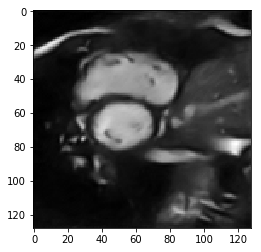

saving epoch {56}
Epoch: 57, Iteration: 1, Loss: 0.000532550853677094, time: 2019-08-04 07:48:39.375012
Epoch: 57, Iteration: 101, Loss: 0.06332991967792623, time: 2019-08-04 07:50:40.469755
Epoch: 57, Iteration: 201, Loss: 0.1266679125110386, time: 2019-08-04 07:52:41.035073
Epoch: 57, Iteration: 301, Loss: 0.18926173138606828, time: 2019-08-04 07:54:41.896269
Epoch: 57, Iteration: 401, Loss: 0.24928995910158847, time: 2019-08-04 07:56:43.167783
Epoch: 57, Iteration: 501, Loss: 0.3188434397306992, time: 2019-08-04 07:58:45.596169
Epoch: 57, Iteration: 601, Loss: 0.3861379106674576, time: 2019-08-04 08:00:47.131153
Epoch: 57, Iteration: 701, Loss: 0.4607129128125962, time: 2019-08-04 08:02:48.722258
Epoch: 57, Iteration: 801, Loss: 0.5256757017050404, time: 2019-08-04 08:04:50.081786
Epoch: 57, Iteration: 901, Loss: 0.5920854604337364, time: 2019-08-04 08:06:51.311899
Epoch: 57, Iteration: 1001, Loss: 0.657903272745898, time: 2019-08-04 08:08:53.189401
Epoch: 57, Iteration: 1101, Loss:

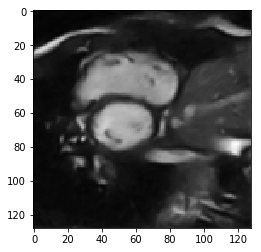

saving epoch {57}
Epoch: 58, Iteration: 1, Loss: 0.00039016446680761874, time: 2019-08-04 08:12:56.938671
Epoch: 58, Iteration: 101, Loss: 0.06228080215805676, time: 2019-08-04 08:14:58.628828
Epoch: 58, Iteration: 201, Loss: 0.13193130765284877, time: 2019-08-04 08:17:00.534892
Epoch: 58, Iteration: 301, Loss: 0.1960268757684389, time: 2019-08-04 08:19:02.187348
Epoch: 58, Iteration: 401, Loss: 0.26524608953332063, time: 2019-08-04 08:21:03.017560
Epoch: 58, Iteration: 501, Loss: 0.3263470170641085, time: 2019-08-04 08:23:04.365120
Epoch: 58, Iteration: 601, Loss: 0.3880617952818284, time: 2019-08-04 08:25:05.276548
Epoch: 58, Iteration: 701, Loss: 0.45696804019098636, time: 2019-08-04 08:27:06.710108
Epoch: 58, Iteration: 801, Loss: 0.5229257390165003, time: 2019-08-04 08:29:08.463330
Epoch: 58, Iteration: 901, Loss: 0.5892050148831913, time: 2019-08-04 08:31:09.058202
Epoch: 58, Iteration: 1001, Loss: 0.6598377846676158, time: 2019-08-04 08:33:10.586431
Epoch: 58, Iteration: 1101, L

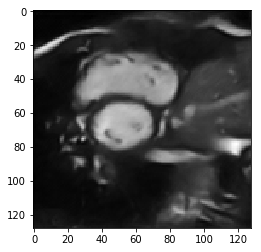

saving epoch {58}
Epoch: 59, Iteration: 1, Loss: 0.0006983380881138146, time: 2019-08-04 08:37:11.216164
Epoch: 59, Iteration: 101, Loss: 0.06507703123497777, time: 2019-08-04 08:39:09.534306
Epoch: 59, Iteration: 201, Loss: 0.12294680080958642, time: 2019-08-04 08:41:07.546563
Epoch: 59, Iteration: 301, Loss: 0.18415582389570773, time: 2019-08-04 08:43:05.145575
Epoch: 59, Iteration: 401, Loss: 0.2435949229693506, time: 2019-08-04 08:45:02.836609
Epoch: 59, Iteration: 501, Loss: 0.312965945515316, time: 2019-08-04 08:47:00.446064
Epoch: 59, Iteration: 601, Loss: 0.37962686803075485, time: 2019-08-04 08:48:58.042009
Epoch: 59, Iteration: 701, Loss: 0.44155727879842743, time: 2019-08-04 08:50:55.553533
Epoch: 59, Iteration: 801, Loss: 0.5098184132366441, time: 2019-08-04 08:52:53.033978
Epoch: 59, Iteration: 901, Loss: 0.5800251957407454, time: 2019-08-04 08:54:50.654747
Epoch: 59, Iteration: 1001, Loss: 0.6445885621506022, time: 2019-08-04 08:56:48.153460
Epoch: 59, Iteration: 1101, Lo

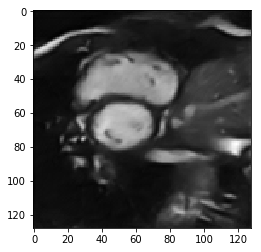

saving epoch {59}
Epoch: 60, Iteration: 1, Loss: 0.0007523888489231467, time: 2019-08-04 09:00:43.848803
Epoch: 60, Iteration: 101, Loss: 0.05903792841127142, time: 2019-08-04 09:02:41.268236
Epoch: 60, Iteration: 201, Loss: 0.12081691625644453, time: 2019-08-04 09:04:38.856832
Epoch: 60, Iteration: 301, Loss: 0.1811413554532919, time: 2019-08-04 09:06:36.274557
Epoch: 60, Iteration: 401, Loss: 0.24408947533811443, time: 2019-08-04 09:08:33.838081
Epoch: 60, Iteration: 501, Loss: 0.3086085396935232, time: 2019-08-04 09:10:31.294780
Epoch: 60, Iteration: 601, Loss: 0.38057301694061607, time: 2019-08-04 09:12:28.933778
Epoch: 60, Iteration: 701, Loss: 0.45572574753896333, time: 2019-08-04 09:14:26.325990
Epoch: 60, Iteration: 801, Loss: 0.5317866085388232, time: 2019-08-04 09:16:23.852374
Epoch: 60, Iteration: 901, Loss: 0.597514570428757, time: 2019-08-04 09:18:21.215396
Epoch: 60, Iteration: 1001, Loss: 0.6650406561529962, time: 2019-08-04 09:20:18.736555
Epoch: 60, Iteration: 1101, Lo

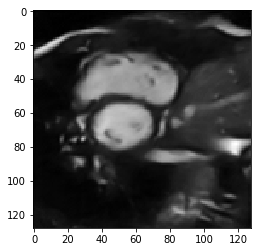

saving epoch {60}
Epoch: 61, Iteration: 1, Loss: 0.00042205388308502734, time: 2019-08-04 09:24:14.446306
Epoch: 61, Iteration: 101, Loss: 0.06596952161635272, time: 2019-08-04 09:26:11.886123
Epoch: 61, Iteration: 201, Loss: 0.12731681441073306, time: 2019-08-04 09:28:09.333348
Epoch: 61, Iteration: 301, Loss: 0.1873031395371072, time: 2019-08-04 09:30:06.773672
Epoch: 61, Iteration: 401, Loss: 0.24934160489647184, time: 2019-08-04 09:32:04.186703
Epoch: 61, Iteration: 501, Loss: 0.3102927426662063, time: 2019-08-04 09:34:01.853928
Epoch: 61, Iteration: 601, Loss: 0.37392359162913635, time: 2019-08-04 09:35:59.220326
Epoch: 61, Iteration: 701, Loss: 0.4366876615677029, time: 2019-08-04 09:37:56.591841
Epoch: 61, Iteration: 801, Loss: 0.5027688968984876, time: 2019-08-04 09:39:54.009315
Epoch: 61, Iteration: 901, Loss: 0.5627004631969612, time: 2019-08-04 09:41:51.386078
Epoch: 61, Iteration: 1001, Loss: 0.6251966945419554, time: 2019-08-04 09:43:48.855839
Epoch: 61, Iteration: 1101, L

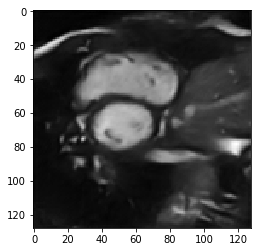

saving epoch {61}
Epoch: 62, Iteration: 1, Loss: 0.0008377628400921822, time: 2019-08-04 09:47:44.579287
Epoch: 62, Iteration: 101, Loss: 0.06850917874544393, time: 2019-08-04 09:49:41.956252
Epoch: 62, Iteration: 201, Loss: 0.13699034827004652, time: 2019-08-04 09:51:39.326832
Epoch: 62, Iteration: 301, Loss: 0.19914110560785048, time: 2019-08-04 09:53:36.720945
Epoch: 62, Iteration: 401, Loss: 0.26489505558856763, time: 2019-08-04 09:55:34.145579
Epoch: 62, Iteration: 501, Loss: 0.33393765025539324, time: 2019-08-04 09:57:31.562606
Epoch: 62, Iteration: 601, Loss: 0.40296069244504906, time: 2019-08-04 09:59:29.045707
Epoch: 62, Iteration: 701, Loss: 0.4668838433281053, time: 2019-08-04 10:01:26.428527
Epoch: 62, Iteration: 801, Loss: 0.5307793568936177, time: 2019-08-04 10:03:23.922694
Epoch: 62, Iteration: 901, Loss: 0.5914115459017921, time: 2019-08-04 10:05:21.433483
Epoch: 62, Iteration: 1001, Loss: 0.6595940780534875, time: 2019-08-04 10:07:18.919165
Epoch: 62, Iteration: 1101, 

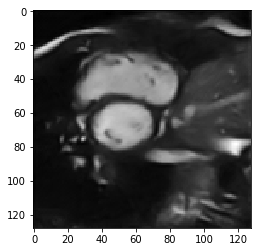

saving epoch {62}
Epoch: 63, Iteration: 1, Loss: 0.0005756741156801581, time: 2019-08-04 10:11:14.704314
Epoch: 63, Iteration: 101, Loss: 0.06846321871853434, time: 2019-08-04 10:13:12.210689
Epoch: 63, Iteration: 201, Loss: 0.13911339759943075, time: 2019-08-04 10:15:09.663008
Epoch: 63, Iteration: 301, Loss: 0.19537188205868006, time: 2019-08-04 10:17:07.101338
Epoch: 63, Iteration: 401, Loss: 0.25561764485610183, time: 2019-08-04 10:19:04.546340
Epoch: 63, Iteration: 501, Loss: 0.312846148837707, time: 2019-08-04 10:21:01.899278
Epoch: 63, Iteration: 601, Loss: 0.3800580889073899, time: 2019-08-04 10:22:59.308356
Epoch: 63, Iteration: 701, Loss: 0.4466866476723226, time: 2019-08-04 10:24:56.836639
Epoch: 63, Iteration: 801, Loss: 0.5108671591005987, time: 2019-08-04 10:26:54.228915
Epoch: 63, Iteration: 901, Loss: 0.5750417632661993, time: 2019-08-04 10:28:51.732077
Epoch: 63, Iteration: 1001, Loss: 0.6360508660873165, time: 2019-08-04 10:30:49.134553
Epoch: 63, Iteration: 1101, Los

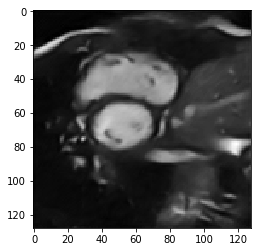

saving epoch {63}
Epoch: 64, Iteration: 1, Loss: 0.0008388754213228822, time: 2019-08-04 10:34:44.837583
Epoch: 64, Iteration: 101, Loss: 0.06075076409615576, time: 2019-08-04 10:36:42.276525
Epoch: 64, Iteration: 201, Loss: 0.13185982120921835, time: 2019-08-04 10:38:39.833770
Epoch: 64, Iteration: 301, Loss: 0.1927793999784626, time: 2019-08-04 10:40:37.205533
Epoch: 64, Iteration: 401, Loss: 0.2539918392722029, time: 2019-08-04 10:42:34.690190
Epoch: 64, Iteration: 501, Loss: 0.31939366133883595, time: 2019-08-04 10:44:32.200282
Epoch: 64, Iteration: 601, Loss: 0.37752834815182723, time: 2019-08-04 10:46:29.561322
Epoch: 64, Iteration: 701, Loss: 0.4418432614329504, time: 2019-08-04 10:48:27.035884
Epoch: 64, Iteration: 801, Loss: 0.5045800406805938, time: 2019-08-04 10:50:24.495175
Epoch: 64, Iteration: 901, Loss: 0.5669738461438101, time: 2019-08-04 10:52:21.924575
Epoch: 64, Iteration: 1001, Loss: 0.63106296742626, time: 2019-08-04 10:54:19.323024
Epoch: 64, Iteration: 1101, Loss

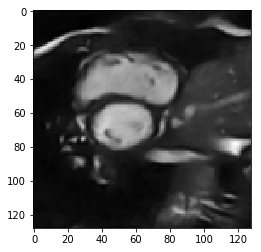

saving epoch {64}
Epoch: 65, Iteration: 1, Loss: 0.0010016298620030284, time: 2019-08-04 10:58:14.910754
Epoch: 65, Iteration: 101, Loss: 0.06884554744465277, time: 2019-08-04 11:00:12.416669
Epoch: 65, Iteration: 201, Loss: 0.13370110164396465, time: 2019-08-04 11:02:09.820046
Epoch: 65, Iteration: 301, Loss: 0.19642437742732, time: 2019-08-04 11:04:07.195646
Epoch: 65, Iteration: 401, Loss: 0.2582470377528807, time: 2019-08-04 11:06:04.579373
Epoch: 65, Iteration: 501, Loss: 0.3234824369865237, time: 2019-08-04 11:08:01.965363
Epoch: 65, Iteration: 601, Loss: 0.3920924298436148, time: 2019-08-04 11:09:59.410561
Epoch: 65, Iteration: 701, Loss: 0.4517092911846703, time: 2019-08-04 11:11:56.805065
Epoch: 65, Iteration: 801, Loss: 0.5172934354050085, time: 2019-08-04 11:13:54.375214
Epoch: 65, Iteration: 901, Loss: 0.589070888934657, time: 2019-08-04 11:15:51.906582
Epoch: 65, Iteration: 1001, Loss: 0.6530014654272236, time: 2019-08-04 11:17:49.381968
Epoch: 65, Iteration: 1101, Loss: 0

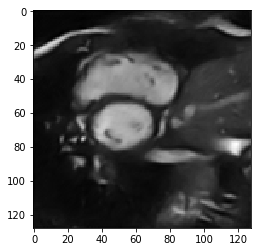

saving epoch {65}
Epoch: 66, Iteration: 1, Loss: 0.0007083684904500842, time: 2019-08-04 11:21:45.100494
Epoch: 66, Iteration: 101, Loss: 0.06458224236848764, time: 2019-08-04 11:23:42.712578
Epoch: 66, Iteration: 201, Loss: 0.12436504906509072, time: 2019-08-04 11:25:40.207565
Epoch: 66, Iteration: 301, Loss: 0.19060663992422633, time: 2019-08-04 11:27:37.597238
Epoch: 66, Iteration: 401, Loss: 0.2542320289358031, time: 2019-08-04 11:29:35.001023
Epoch: 66, Iteration: 501, Loss: 0.31652736046817154, time: 2019-08-04 11:31:32.491279
Epoch: 66, Iteration: 601, Loss: 0.37761232795310207, time: 2019-08-04 11:33:29.948492
Epoch: 66, Iteration: 701, Loss: 0.43731860315892845, time: 2019-08-04 11:35:27.378227
Epoch: 66, Iteration: 801, Loss: 0.49852787438430823, time: 2019-08-04 11:37:24.839547
Epoch: 66, Iteration: 901, Loss: 0.5579577016615076, time: 2019-08-04 11:39:22.291383
Epoch: 66, Iteration: 1001, Loss: 0.6167000060522696, time: 2019-08-04 11:41:19.675818
Epoch: 66, Iteration: 1101,

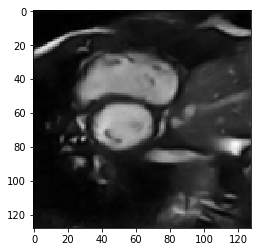

saving epoch {66}
Epoch: 67, Iteration: 1, Loss: 0.0003479790175333619, time: 2019-08-04 11:45:15.377295
Epoch: 67, Iteration: 101, Loss: 0.06309086384135298, time: 2019-08-04 11:47:12.791419
Epoch: 67, Iteration: 201, Loss: 0.12229205943003763, time: 2019-08-04 11:49:10.273351
Epoch: 67, Iteration: 301, Loss: 0.18566364469006658, time: 2019-08-04 11:51:07.677203
Epoch: 67, Iteration: 401, Loss: 0.2464958454365842, time: 2019-08-04 11:53:05.075637
Epoch: 67, Iteration: 501, Loss: 0.3070760163391242, time: 2019-08-04 11:55:02.533888
Epoch: 67, Iteration: 601, Loss: 0.36585093193571083, time: 2019-08-04 11:57:00.040072
Epoch: 67, Iteration: 701, Loss: 0.43423228108440526, time: 2019-08-04 11:58:57.483660
Epoch: 67, Iteration: 801, Loss: 0.49899325813748874, time: 2019-08-04 12:00:54.974887
Epoch: 67, Iteration: 901, Loss: 0.5571224768063985, time: 2019-08-04 12:02:52.428595
Epoch: 67, Iteration: 1001, Loss: 0.6287738884275313, time: 2019-08-04 12:04:49.866317
Epoch: 67, Iteration: 1101, 

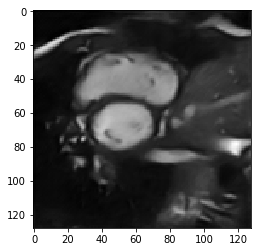

saving epoch {67}
Epoch: 68, Iteration: 1, Loss: 0.0006303159752860665, time: 2019-08-04 12:08:45.599910
Epoch: 68, Iteration: 101, Loss: 0.06977369825472124, time: 2019-08-04 12:10:42.966100
Epoch: 68, Iteration: 201, Loss: 0.13497467416164, time: 2019-08-04 12:12:40.415048
Epoch: 68, Iteration: 301, Loss: 0.20293885657156352, time: 2019-08-04 12:14:37.925212
Epoch: 68, Iteration: 401, Loss: 0.26372439206170384, time: 2019-08-04 12:16:35.391384
Epoch: 68, Iteration: 501, Loss: 0.32258844036550727, time: 2019-08-04 12:18:32.887631
Epoch: 68, Iteration: 601, Loss: 0.38199579597858246, time: 2019-08-04 12:20:30.317052
Epoch: 68, Iteration: 701, Loss: 0.4436870169447502, time: 2019-08-04 12:22:27.826369
Epoch: 68, Iteration: 801, Loss: 0.5042567574855639, time: 2019-08-04 12:24:25.263223
Epoch: 68, Iteration: 901, Loss: 0.5662678224471165, time: 2019-08-04 12:26:22.693753
Epoch: 68, Iteration: 1001, Loss: 0.6251987011783058, time: 2019-08-04 12:28:20.098280
Epoch: 68, Iteration: 1101, Los

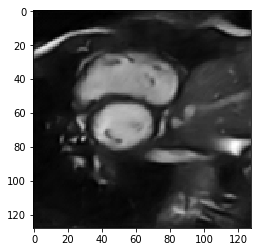

saving epoch {68}
Epoch: 69, Iteration: 1, Loss: 0.0005383609095588326, time: 2019-08-04 12:32:15.769235
Epoch: 69, Iteration: 101, Loss: 0.060725096831447445, time: 2019-08-04 12:34:13.347733
Epoch: 69, Iteration: 201, Loss: 0.12415812620020006, time: 2019-08-04 12:36:10.729678
Epoch: 69, Iteration: 301, Loss: 0.1892287312221015, time: 2019-08-04 12:38:08.307974
Epoch: 69, Iteration: 401, Loss: 0.2487462649733061, time: 2019-08-04 12:40:05.809190
Epoch: 69, Iteration: 501, Loss: 0.3067388956405921, time: 2019-08-04 12:42:03.211550
Epoch: 69, Iteration: 601, Loss: 0.3706943214056082, time: 2019-08-04 12:44:00.689433
Epoch: 69, Iteration: 701, Loss: 0.43149843177525327, time: 2019-08-04 12:45:58.087733
Epoch: 69, Iteration: 801, Loss: 0.49513757502427325, time: 2019-08-04 12:47:55.599562
Epoch: 69, Iteration: 901, Loss: 0.5509962662617909, time: 2019-08-04 12:49:52.930639
Epoch: 69, Iteration: 1001, Loss: 0.6109929874655791, time: 2019-08-04 12:51:50.347973
Epoch: 69, Iteration: 1101, L

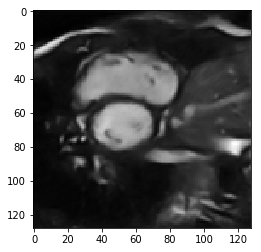

saving epoch {69}
Epoch: 70, Iteration: 1, Loss: 0.0006646747933700681, time: 2019-08-04 12:55:46.189566
Epoch: 70, Iteration: 101, Loss: 0.06291672057705, time: 2019-08-04 12:57:43.717429
Epoch: 70, Iteration: 201, Loss: 0.1274401485279668, time: 2019-08-04 12:59:41.245072
Epoch: 70, Iteration: 301, Loss: 0.18993343721376732, time: 2019-08-04 13:01:38.743992
Epoch: 70, Iteration: 401, Loss: 0.2556615736830281, time: 2019-08-04 13:03:36.227379
Epoch: 70, Iteration: 501, Loss: 0.3156507316016359, time: 2019-08-04 13:05:33.658165
Epoch: 70, Iteration: 601, Loss: 0.38387889407749753, time: 2019-08-04 13:07:31.048136
Epoch: 70, Iteration: 701, Loss: 0.44438310631085187, time: 2019-08-04 13:09:28.620117
Epoch: 70, Iteration: 801, Loss: 0.5102101655793376, time: 2019-08-04 13:11:26.052514
Epoch: 70, Iteration: 901, Loss: 0.5727557014324702, time: 2019-08-04 13:13:23.450184
Epoch: 70, Iteration: 1001, Loss: 0.6366186091327108, time: 2019-08-04 13:15:20.947782
Epoch: 70, Iteration: 1101, Loss:

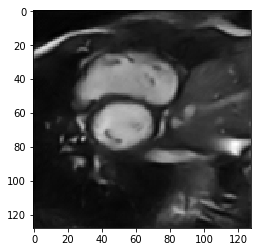

saving epoch {70}
Epoch: 71, Iteration: 1, Loss: 0.0005555144161917269, time: 2019-08-04 13:19:16.687720
Epoch: 71, Iteration: 101, Loss: 0.059275828331010416, time: 2019-08-04 13:21:14.232327
Epoch: 71, Iteration: 201, Loss: 0.1247806319152005, time: 2019-08-04 13:23:11.635294
Epoch: 71, Iteration: 301, Loss: 0.18594985420349985, time: 2019-08-04 13:25:09.118912
Epoch: 71, Iteration: 401, Loss: 0.24008115964534227, time: 2019-08-04 13:27:06.514420
Epoch: 71, Iteration: 501, Loss: 0.3007237542042276, time: 2019-08-04 13:29:03.998739
Epoch: 71, Iteration: 601, Loss: 0.3598263345338637, time: 2019-08-04 13:31:01.496844
Epoch: 71, Iteration: 701, Loss: 0.4298110888048541, time: 2019-08-04 13:32:58.940287
Epoch: 71, Iteration: 801, Loss: 0.49118516710586846, time: 2019-08-04 13:34:56.422893
Epoch: 71, Iteration: 901, Loss: 0.5528009882400511, time: 2019-08-04 13:36:53.812927
Epoch: 71, Iteration: 1001, Loss: 0.6096356200432638, time: 2019-08-04 13:38:51.210951
Epoch: 71, Iteration: 1101, L

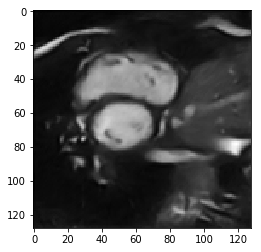

saving epoch {71}
Epoch: 72, Iteration: 1, Loss: 0.0004897930775769055, time: 2019-08-04 13:42:46.978009
Epoch: 72, Iteration: 101, Loss: 0.06374424591194838, time: 2019-08-04 13:44:44.404617
Epoch: 72, Iteration: 201, Loss: 0.1256132805137895, time: 2019-08-04 13:46:41.847038
Epoch: 72, Iteration: 301, Loss: 0.18522977738757618, time: 2019-08-04 13:48:39.350695
Epoch: 72, Iteration: 401, Loss: 0.2498963141697459, time: 2019-08-04 13:50:36.884994
Epoch: 72, Iteration: 501, Loss: 0.3078518336697016, time: 2019-08-04 13:52:34.333011
Epoch: 72, Iteration: 601, Loss: 0.36784885873203166, time: 2019-08-04 13:54:31.857120
Epoch: 72, Iteration: 701, Loss: 0.4243808368919417, time: 2019-08-04 13:56:29.365373
Epoch: 72, Iteration: 801, Loss: 0.49318716570269316, time: 2019-08-04 13:58:26.897883
Epoch: 72, Iteration: 901, Loss: 0.5574893291341141, time: 2019-08-04 14:00:24.575980
Epoch: 72, Iteration: 1001, Loss: 0.6190379724139348, time: 2019-08-04 14:02:22.035220
Epoch: 72, Iteration: 1101, Lo

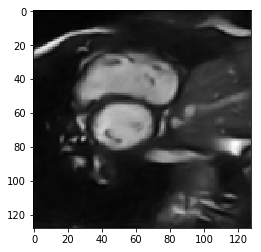

saving epoch {72}
Epoch: 73, Iteration: 1, Loss: 0.0004496003093663603, time: 2019-08-04 14:06:18.079130
Epoch: 73, Iteration: 101, Loss: 0.05884844469255768, time: 2019-08-04 14:08:15.363733
Epoch: 73, Iteration: 201, Loss: 0.1167609803378582, time: 2019-08-04 14:10:12.676309
Epoch: 73, Iteration: 301, Loss: 0.18085971041000448, time: 2019-08-04 14:12:09.941183
Epoch: 73, Iteration: 401, Loss: 0.2396874839614611, time: 2019-08-04 14:14:07.212550
Epoch: 73, Iteration: 501, Loss: 0.29821099890978076, time: 2019-08-04 14:16:04.503269
Epoch: 73, Iteration: 601, Loss: 0.35894811610342003, time: 2019-08-04 14:18:01.676745
Epoch: 73, Iteration: 701, Loss: 0.4161754386877874, time: 2019-08-04 14:19:59.012390
Epoch: 73, Iteration: 801, Loss: 0.4727924816979794, time: 2019-08-04 14:21:56.370588
Epoch: 73, Iteration: 901, Loss: 0.541581190758734, time: 2019-08-04 14:23:53.636015
Epoch: 73, Iteration: 1001, Loss: 0.6136666629026877, time: 2019-08-04 14:25:50.894804
Epoch: 73, Iteration: 1101, Los

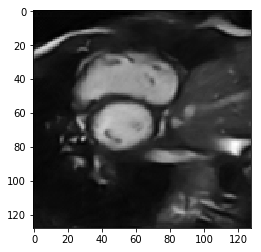

saving epoch {73}
Epoch: 74, Iteration: 1, Loss: 0.0005323151708580554, time: 2019-08-04 14:29:46.527243
Epoch: 74, Iteration: 101, Loss: 0.06125422613695264, time: 2019-08-04 14:31:43.793577
Epoch: 74, Iteration: 201, Loss: 0.12422001780942082, time: 2019-08-04 14:33:41.193986
Epoch: 74, Iteration: 301, Loss: 0.1780294915806735, time: 2019-08-04 14:35:38.556750
Epoch: 74, Iteration: 401, Loss: 0.23709443320694845, time: 2019-08-04 14:37:35.969165
Epoch: 74, Iteration: 501, Loss: 0.29490735140279867, time: 2019-08-04 14:39:33.345882
Epoch: 74, Iteration: 601, Loss: 0.3555100694356952, time: 2019-08-04 14:41:30.823503
Epoch: 74, Iteration: 701, Loss: 0.41685354625224136, time: 2019-08-04 14:43:28.206695
Epoch: 74, Iteration: 801, Loss: 0.47904232049768325, time: 2019-08-04 14:45:25.536945
Epoch: 74, Iteration: 901, Loss: 0.5428720188065199, time: 2019-08-04 14:47:22.809437
Epoch: 74, Iteration: 1001, Loss: 0.6036311781645054, time: 2019-08-04 14:49:20.166581
Epoch: 74, Iteration: 1101, 

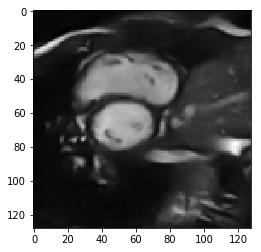

saving epoch {74}
Epoch: 75, Iteration: 1, Loss: 0.00033245523809455335, time: 2019-08-04 14:53:15.692897
Epoch: 75, Iteration: 101, Loss: 0.05983760257367976, time: 2019-08-04 14:55:13.021146
Epoch: 75, Iteration: 201, Loss: 0.11720741218596231, time: 2019-08-04 14:57:10.272039
Epoch: 75, Iteration: 301, Loss: 0.18519844846741762, time: 2019-08-04 14:59:07.590243
Epoch: 75, Iteration: 401, Loss: 0.25252788882062305, time: 2019-08-04 15:01:04.957327
Epoch: 75, Iteration: 501, Loss: 0.3105094169441145, time: 2019-08-04 15:03:02.334885
Epoch: 75, Iteration: 601, Loss: 0.3727398202463519, time: 2019-08-04 15:04:59.665657
Epoch: 75, Iteration: 701, Loss: 0.4369448951911181, time: 2019-08-04 15:06:56.941321
Epoch: 75, Iteration: 801, Loss: 0.5005495931400219, time: 2019-08-04 15:08:54.406936
Epoch: 75, Iteration: 901, Loss: 0.5612281466455897, time: 2019-08-04 15:10:51.854796
Epoch: 75, Iteration: 1001, Loss: 0.6215727505041286, time: 2019-08-04 15:12:49.304119
Epoch: 75, Iteration: 1101, L

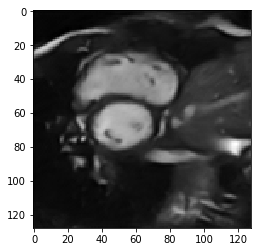

saving epoch {75}
Epoch: 76, Iteration: 1, Loss: 0.0003848170454148203, time: 2019-08-04 15:16:44.796732
Epoch: 76, Iteration: 101, Loss: 0.06217893956636544, time: 2019-08-04 15:18:42.171842
Epoch: 76, Iteration: 201, Loss: 0.12414470333897043, time: 2019-08-04 15:20:39.506427
Epoch: 76, Iteration: 301, Loss: 0.18130014541384298, time: 2019-08-04 15:22:36.827006
Epoch: 76, Iteration: 401, Loss: 0.23969559495162684, time: 2019-08-04 15:24:34.283053
Epoch: 76, Iteration: 501, Loss: 0.30055261992674787, time: 2019-08-04 15:26:31.612982
Epoch: 76, Iteration: 601, Loss: 0.3583261565800058, time: 2019-08-04 15:28:28.953553
Epoch: 76, Iteration: 701, Loss: 0.4210620333615225, time: 2019-08-04 15:30:26.348095
Epoch: 76, Iteration: 801, Loss: 0.48378952813800424, time: 2019-08-04 15:32:23.910339
Epoch: 76, Iteration: 901, Loss: 0.5430096226918977, time: 2019-08-04 15:34:21.245784
Epoch: 76, Iteration: 1001, Loss: 0.601092700380832, time: 2019-08-04 15:36:18.629101
Epoch: 76, Iteration: 1101, L

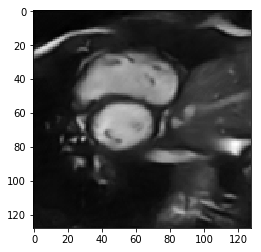

saving epoch {76}
Epoch: 77, Iteration: 1, Loss: 0.0005640176241286099, time: 2019-08-04 15:40:14.212657
Epoch: 77, Iteration: 101, Loss: 0.05968084391497541, time: 2019-08-04 15:42:11.513710
Epoch: 77, Iteration: 201, Loss: 0.11805379526049364, time: 2019-08-04 15:44:08.807404
Epoch: 77, Iteration: 301, Loss: 0.18364415355608799, time: 2019-08-04 15:46:06.163774
Epoch: 77, Iteration: 401, Loss: 0.24595710188441444, time: 2019-08-04 15:48:03.640776
Epoch: 77, Iteration: 501, Loss: 0.3066220659966348, time: 2019-08-04 15:50:01.128697
Epoch: 77, Iteration: 601, Loss: 0.36057553796854336, time: 2019-08-04 15:51:58.575351
Epoch: 77, Iteration: 701, Loss: 0.41741522756638005, time: 2019-08-04 15:53:55.999043
Epoch: 77, Iteration: 801, Loss: 0.4755133594153449, time: 2019-08-04 15:55:53.504625
Epoch: 77, Iteration: 901, Loss: 0.5338504963729065, time: 2019-08-04 15:57:51.009942
Epoch: 77, Iteration: 1001, Loss: 0.5899211262294557, time: 2019-08-04 15:59:48.421904
Epoch: 77, Iteration: 1101, 

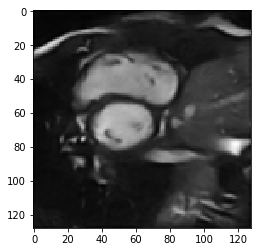

saving epoch {77}
Epoch: 78, Iteration: 1, Loss: 0.0008343493682332337, time: 2019-08-04 16:03:44.349030
Epoch: 78, Iteration: 101, Loss: 0.05393250897759572, time: 2019-08-04 16:05:41.761367
Epoch: 78, Iteration: 201, Loss: 0.11588388370000757, time: 2019-08-04 16:07:39.140045
Epoch: 78, Iteration: 301, Loss: 0.18135970123694278, time: 2019-08-04 16:09:36.535216
Epoch: 78, Iteration: 401, Loss: 0.23784332876675762, time: 2019-08-04 16:11:34.052696
Epoch: 78, Iteration: 501, Loss: 0.2985348113870714, time: 2019-08-04 16:13:31.419041
Epoch: 78, Iteration: 601, Loss: 0.3656552280008327, time: 2019-08-04 16:15:28.804434
Epoch: 78, Iteration: 701, Loss: 0.429023858247092, time: 2019-08-04 16:17:26.150613
Epoch: 78, Iteration: 801, Loss: 0.4896868703654036, time: 2019-08-04 16:19:23.621688
Epoch: 78, Iteration: 901, Loss: 0.5524033794354182, time: 2019-08-04 16:21:20.987639
Epoch: 78, Iteration: 1001, Loss: 0.6142907292523887, time: 2019-08-04 16:23:18.359283
Epoch: 78, Iteration: 1101, Los

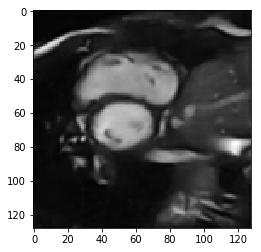

saving epoch {78}
Epoch: 79, Iteration: 1, Loss: 0.0004148116277065128, time: 2019-08-04 16:27:14.017825
Epoch: 79, Iteration: 101, Loss: 0.05813428922556341, time: 2019-08-04 16:29:11.501838
Epoch: 79, Iteration: 201, Loss: 0.11362748873943929, time: 2019-08-04 16:31:08.916194
Epoch: 79, Iteration: 301, Loss: 0.17518071010999847, time: 2019-08-04 16:33:06.356468
Epoch: 79, Iteration: 401, Loss: 0.2347037008148618, time: 2019-08-04 16:35:03.825860
Epoch: 79, Iteration: 501, Loss: 0.2940256782749202, time: 2019-08-04 16:37:01.169651
Epoch: 79, Iteration: 601, Loss: 0.3548880562593695, time: 2019-08-04 16:38:58.613230
Epoch: 79, Iteration: 701, Loss: 0.4164018217998091, time: 2019-08-04 16:40:55.974264
Epoch: 79, Iteration: 801, Loss: 0.4741316233703401, time: 2019-08-04 16:42:53.366573
Epoch: 79, Iteration: 901, Loss: 0.5327421548281563, time: 2019-08-04 16:44:50.776958
Epoch: 79, Iteration: 1001, Loss: 0.5961545683967415, time: 2019-08-04 16:46:48.173281
Epoch: 79, Iteration: 1101, Los

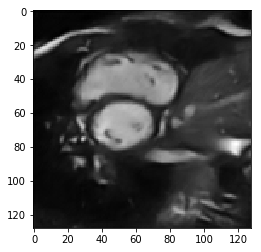

saving epoch {79}
Epoch: 80, Iteration: 1, Loss: 0.0006378277903422713, time: 2019-08-04 16:50:44.018434
Epoch: 80, Iteration: 101, Loss: 0.05684275823296048, time: 2019-08-04 16:52:41.417436
Epoch: 80, Iteration: 201, Loss: 0.10972408665111288, time: 2019-08-04 16:54:39.200964
Epoch: 80, Iteration: 301, Loss: 0.1677126565191429, time: 2019-08-04 16:56:38.032271
Epoch: 80, Iteration: 401, Loss: 0.2234560550423339, time: 2019-08-04 16:58:37.311438
Epoch: 80, Iteration: 501, Loss: 0.2850209253083449, time: 2019-08-04 17:00:35.928234
Epoch: 80, Iteration: 601, Loss: 0.34543794044293463, time: 2019-08-04 17:02:34.625819
Epoch: 80, Iteration: 701, Loss: 0.40633609882206656, time: 2019-08-04 17:04:32.630338
Epoch: 80, Iteration: 801, Loss: 0.4689874254981987, time: 2019-08-04 17:06:30.134750
Epoch: 80, Iteration: 901, Loss: 0.5313037752785021, time: 2019-08-04 17:08:27.634813
Epoch: 80, Iteration: 1001, Loss: 0.5996088049869286, time: 2019-08-04 17:10:25.108973
Epoch: 80, Iteration: 1101, Lo

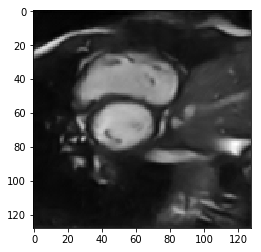

saving epoch {80}
Epoch: 81, Iteration: 1, Loss: 0.0003803637810051441, time: 2019-08-04 17:14:21.218613
Epoch: 81, Iteration: 101, Loss: 0.06148890579061117, time: 2019-08-04 17:16:18.676488
Epoch: 81, Iteration: 201, Loss: 0.12030738135217689, time: 2019-08-04 17:18:16.286196
Epoch: 81, Iteration: 301, Loss: 0.1842077255132608, time: 2019-08-04 17:20:13.786296
Epoch: 81, Iteration: 401, Loss: 0.24610917689278722, time: 2019-08-04 17:22:11.266020
Epoch: 81, Iteration: 501, Loss: 0.3096292926929891, time: 2019-08-04 17:24:08.834493
Epoch: 81, Iteration: 601, Loss: 0.3672887933498714, time: 2019-08-04 17:26:06.356000
Epoch: 81, Iteration: 701, Loss: 0.42379027625429444, time: 2019-08-04 17:28:04.733169
Epoch: 81, Iteration: 801, Loss: 0.4838335646491032, time: 2019-08-04 17:30:04.755996
Epoch: 81, Iteration: 901, Loss: 0.5394424902478931, time: 2019-08-04 17:32:05.037406
Epoch: 81, Iteration: 1001, Loss: 0.5967586927145021, time: 2019-08-04 17:34:05.351662
Epoch: 81, Iteration: 1101, Lo

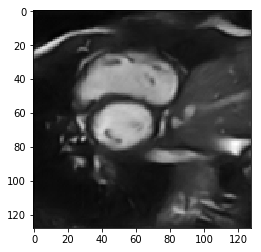

saving epoch {81}
Epoch: 82, Iteration: 1, Loss: 0.0004988241125829518, time: 2019-08-04 17:38:04.118528
Epoch: 82, Iteration: 101, Loss: 0.059251260783639736, time: 2019-08-04 17:40:03.512048
Epoch: 82, Iteration: 201, Loss: 0.11451492033666, time: 2019-08-04 17:42:03.466161
Epoch: 82, Iteration: 301, Loss: 0.17227135074790567, time: 2019-08-04 17:44:04.404329
Epoch: 82, Iteration: 401, Loss: 0.2295610281289555, time: 2019-08-04 17:46:06.227427
Epoch: 82, Iteration: 501, Loss: 0.28540437448828015, time: 2019-08-04 17:48:07.651652
Epoch: 82, Iteration: 601, Loss: 0.3409204816707643, time: 2019-08-04 17:50:10.391634
Epoch: 82, Iteration: 701, Loss: 0.3994588711502729, time: 2019-08-04 17:52:12.424290
Epoch: 82, Iteration: 801, Loss: 0.4614494436100358, time: 2019-08-04 17:54:13.309898
Epoch: 82, Iteration: 901, Loss: 0.5290824944968335, time: 2019-08-04 17:56:14.411604
Epoch: 82, Iteration: 1001, Loss: 0.5874631609185599, time: 2019-08-04 17:58:16.358010
Epoch: 82, Iteration: 1101, Loss

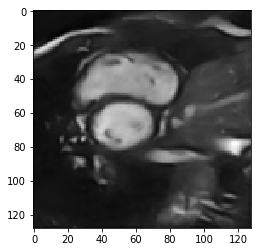

saving epoch {82}
Epoch: 83, Iteration: 1, Loss: 0.0006920607993379235, time: 2019-08-04 18:02:21.423842
Epoch: 83, Iteration: 101, Loss: 0.056705836788751185, time: 2019-08-04 18:04:23.780470
Epoch: 83, Iteration: 201, Loss: 0.11561111560149584, time: 2019-08-04 18:06:25.312116
Epoch: 83, Iteration: 301, Loss: 0.17125643526378553, time: 2019-08-04 18:08:26.876997
Epoch: 83, Iteration: 401, Loss: 0.223625264770817, time: 2019-08-04 18:10:28.600538
Epoch: 83, Iteration: 501, Loss: 0.28149860429402906, time: 2019-08-04 18:12:29.702488
Epoch: 83, Iteration: 601, Loss: 0.343141912802821, time: 2019-08-04 18:14:31.286683
Epoch: 83, Iteration: 701, Loss: 0.4015496059146244, time: 2019-08-04 18:16:32.283286
Epoch: 83, Iteration: 801, Loss: 0.4616741540667135, time: 2019-08-04 18:18:34.255331
Epoch: 83, Iteration: 901, Loss: 0.5157547988346778, time: 2019-08-04 18:20:36.211792
Epoch: 83, Iteration: 1001, Loss: 0.5749785913503729, time: 2019-08-04 18:22:37.106409
Epoch: 83, Iteration: 1101, Los

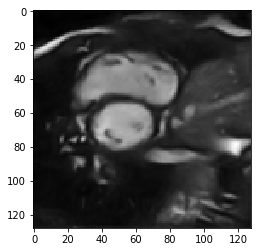

saving epoch {83}
Epoch: 84, Iteration: 1, Loss: 0.0004748162464238703, time: 2019-08-04 18:26:40.017595
Epoch: 84, Iteration: 101, Loss: 0.06632881867699325, time: 2019-08-04 18:28:39.623269
Epoch: 84, Iteration: 201, Loss: 0.12391062836104538, time: 2019-08-04 18:30:39.305054
Epoch: 84, Iteration: 301, Loss: 0.1829486107599223, time: 2019-08-04 18:32:39.905942
Epoch: 84, Iteration: 401, Loss: 0.23892252349469345, time: 2019-08-04 18:34:38.839406
Epoch: 84, Iteration: 501, Loss: 0.2981985529331723, time: 2019-08-04 18:36:38.922362
Epoch: 84, Iteration: 601, Loss: 0.35801293134863954, time: 2019-08-04 18:38:40.073793
Epoch: 84, Iteration: 701, Loss: 0.4245241845928831, time: 2019-08-04 18:40:40.177491
Epoch: 84, Iteration: 801, Loss: 0.4861485276633175, time: 2019-08-04 18:42:39.926984
Epoch: 84, Iteration: 901, Loss: 0.5397334896988468, time: 2019-08-04 18:44:38.887765
Epoch: 84, Iteration: 1001, Loss: 0.6038701941433828, time: 2019-08-04 18:46:37.584182
Epoch: 84, Iteration: 1101, Lo

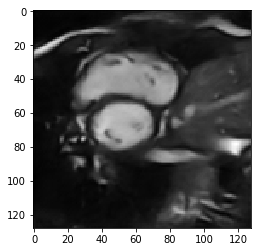

saving epoch {84}
Epoch: 85, Iteration: 1, Loss: 0.00024135627609211951, time: 2019-08-04 18:50:39.721527
Epoch: 85, Iteration: 101, Loss: 0.05458941428514663, time: 2019-08-04 18:52:41.170292
Epoch: 85, Iteration: 201, Loss: 0.1091861695604166, time: 2019-08-04 18:54:42.458121
Epoch: 85, Iteration: 301, Loss: 0.16502760555886198, time: 2019-08-04 18:56:45.347555
Epoch: 85, Iteration: 401, Loss: 0.221707027303637, time: 2019-08-04 18:58:46.337605
Epoch: 85, Iteration: 501, Loss: 0.2790208555961726, time: 2019-08-04 19:00:47.473727
Epoch: 85, Iteration: 601, Loss: 0.33490949431143235, time: 2019-08-04 19:02:47.569418
Epoch: 85, Iteration: 701, Loss: 0.39683849092398304, time: 2019-08-04 19:04:47.165658
Epoch: 85, Iteration: 801, Loss: 0.4544100289203925, time: 2019-08-04 19:06:45.616548
Epoch: 85, Iteration: 901, Loss: 0.5140807850839337, time: 2019-08-04 19:08:44.643387
Epoch: 85, Iteration: 1001, Loss: 0.5760906280775089, time: 2019-08-04 19:10:44.608212
Epoch: 85, Iteration: 1101, Lo

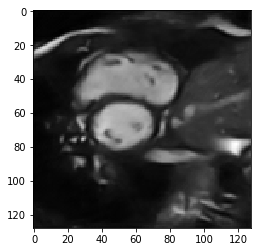

saving epoch {85}
Epoch: 86, Iteration: 1, Loss: 0.0006407647160813212, time: 2019-08-04 19:14:42.225884
Epoch: 86, Iteration: 101, Loss: 0.05648175616806839, time: 2019-08-04 19:16:41.503903
Epoch: 86, Iteration: 201, Loss: 0.11566233278426807, time: 2019-08-04 19:18:41.498430
Epoch: 86, Iteration: 301, Loss: 0.17300871024781372, time: 2019-08-04 19:20:42.701310
Epoch: 86, Iteration: 401, Loss: 0.2356028422509553, time: 2019-08-04 19:22:43.902327
Epoch: 86, Iteration: 501, Loss: 0.2924454313906608, time: 2019-08-04 19:24:45.730654
Epoch: 86, Iteration: 601, Loss: 0.34857646965247113, time: 2019-08-04 19:26:48.585099
Epoch: 86, Iteration: 701, Loss: 0.4056866383034503, time: 2019-08-04 19:28:49.741095
Epoch: 86, Iteration: 801, Loss: 0.4650209580286173, time: 2019-08-04 19:30:49.073672
Epoch: 86, Iteration: 901, Loss: 0.5258414395939326, time: 2019-08-04 19:32:47.765651
Epoch: 86, Iteration: 1001, Loss: 0.5827893319510622, time: 2019-08-04 19:34:46.502164
Epoch: 86, Iteration: 1101, Lo

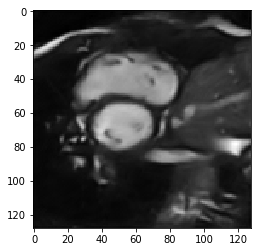

saving epoch {86}
Epoch: 87, Iteration: 1, Loss: 0.00043644392280839384, time: 2019-08-04 19:38:45.819065
Epoch: 87, Iteration: 101, Loss: 0.05294873536331579, time: 2019-08-04 19:40:44.021459
Epoch: 87, Iteration: 201, Loss: 0.10922550322720781, time: 2019-08-04 19:42:42.072874
Epoch: 87, Iteration: 301, Loss: 0.16359891853062436, time: 2019-08-04 19:44:39.994653
Epoch: 87, Iteration: 401, Loss: 0.22081327137129847, time: 2019-08-04 19:46:37.898501
Epoch: 87, Iteration: 501, Loss: 0.27553924785752315, time: 2019-08-04 19:48:36.984494
Epoch: 87, Iteration: 601, Loss: 0.3314594461553497, time: 2019-08-04 19:50:37.047076
Epoch: 87, Iteration: 701, Loss: 0.39007513503020164, time: 2019-08-04 19:52:38.426894
Epoch: 87, Iteration: 801, Loss: 0.4509003259736346, time: 2019-08-04 19:54:39.980031
Epoch: 87, Iteration: 901, Loss: 0.506419162338716, time: 2019-08-04 19:56:41.191665
Epoch: 87, Iteration: 1001, Loss: 0.562603977508843, time: 2019-08-04 19:58:42.909963
Epoch: 87, Iteration: 1101, L

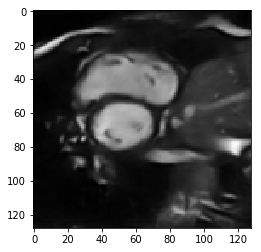

saving epoch {87}
Epoch: 88, Iteration: 1, Loss: 0.00046237846254371107, time: 2019-08-04 20:02:46.987332
Epoch: 88, Iteration: 101, Loss: 0.05575516360113397, time: 2019-08-04 20:04:48.059829
Epoch: 88, Iteration: 201, Loss: 0.1126498992962297, time: 2019-08-04 20:06:49.474210
Epoch: 88, Iteration: 301, Loss: 0.17090196842036676, time: 2019-08-04 20:08:51.346044
Epoch: 88, Iteration: 401, Loss: 0.2390928457461996, time: 2019-08-04 20:10:51.144526
Epoch: 88, Iteration: 501, Loss: 0.2988498648046516, time: 2019-08-04 20:12:50.492334
Epoch: 88, Iteration: 601, Loss: 0.35489462748228107, time: 2019-08-04 20:14:48.877110
Epoch: 88, Iteration: 701, Loss: 0.4146155071357498, time: 2019-08-04 20:16:46.708934
Epoch: 88, Iteration: 801, Loss: 0.47088540204276796, time: 2019-08-04 20:18:44.649706
Epoch: 88, Iteration: 901, Loss: 0.5304688130127033, time: 2019-08-04 20:20:42.623411
Epoch: 88, Iteration: 1001, Loss: 0.5946611663675867, time: 2019-08-04 20:22:40.619725
Epoch: 88, Iteration: 1101, L

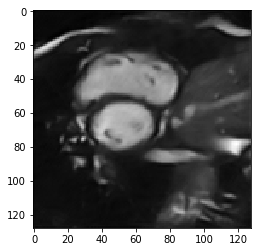

saving epoch {88}
Epoch: 89, Iteration: 1, Loss: 0.0007309684297069907, time: 2019-08-04 20:26:37.553819
Epoch: 89, Iteration: 101, Loss: 0.0547571387141943, time: 2019-08-04 20:28:35.517641
Epoch: 89, Iteration: 201, Loss: 0.11071232144604437, time: 2019-08-04 20:30:33.314304
Epoch: 89, Iteration: 301, Loss: 0.16771041114407126, time: 2019-08-04 20:32:33.314206
Epoch: 89, Iteration: 401, Loss: 0.2271949182904791, time: 2019-08-04 20:34:34.308503
Epoch: 89, Iteration: 501, Loss: 0.28527583289542235, time: 2019-08-04 20:36:35.310985
Epoch: 89, Iteration: 601, Loss: 0.3411782044713618, time: 2019-08-04 20:38:36.845946
Epoch: 89, Iteration: 701, Loss: 0.3901423243514728, time: 2019-08-04 20:40:37.464642
Epoch: 89, Iteration: 801, Loss: 0.44460383646946866, time: 2019-08-04 20:42:36.090119
Epoch: 89, Iteration: 901, Loss: 0.4983779001777293, time: 2019-08-04 20:44:34.512919
Epoch: 89, Iteration: 1001, Loss: 0.552578437156626, time: 2019-08-04 20:46:32.451533
Epoch: 89, Iteration: 1101, Los

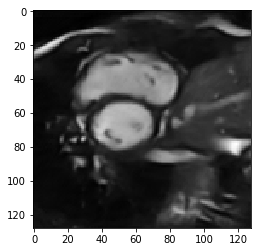

saving epoch {89}
Epoch: 90, Iteration: 1, Loss: 0.0007058872142806649, time: 2019-08-04 20:50:29.238661
Epoch: 90, Iteration: 101, Loss: 0.059727846542955376, time: 2019-08-04 20:52:29.962466
Epoch: 90, Iteration: 201, Loss: 0.11198049956874456, time: 2019-08-04 20:54:30.623381
Epoch: 90, Iteration: 301, Loss: 0.17509629391133785, time: 2019-08-04 20:56:31.479846
Epoch: 90, Iteration: 401, Loss: 0.24958108566352166, time: 2019-08-04 20:58:33.178447
Epoch: 90, Iteration: 501, Loss: 0.31341896901722066, time: 2019-08-04 21:00:34.603390
Epoch: 90, Iteration: 601, Loss: 0.37000819397508167, time: 2019-08-04 21:02:35.487618
Epoch: 90, Iteration: 701, Loss: 0.43135091112344526, time: 2019-08-04 21:04:37.014529
Epoch: 90, Iteration: 801, Loss: 0.4846470691554714, time: 2019-08-04 21:06:38.300366
Epoch: 90, Iteration: 901, Loss: 0.5414769045019057, time: 2019-08-04 21:08:40.492974
Epoch: 90, Iteration: 1001, Loss: 0.5983730233856477, time: 2019-08-04 21:10:41.717455
Epoch: 90, Iteration: 1101

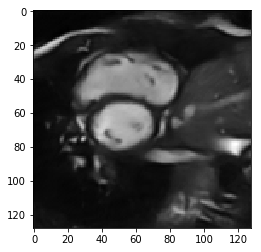

saving epoch {90}
Epoch: 91, Iteration: 1, Loss: 0.0006198769551701844, time: 2019-08-04 21:14:45.249766
Epoch: 91, Iteration: 101, Loss: 0.05048413111944683, time: 2019-08-04 21:16:47.517327
Epoch: 91, Iteration: 201, Loss: 0.10516583701246418, time: 2019-08-04 21:18:49.560146
Epoch: 91, Iteration: 301, Loss: 0.1590128807874862, time: 2019-08-04 21:20:51.545603
Epoch: 91, Iteration: 401, Loss: 0.21826140748453327, time: 2019-08-04 21:22:53.262585
Epoch: 91, Iteration: 501, Loss: 0.2768252288660733, time: 2019-08-04 21:24:54.872984
Epoch: 91, Iteration: 601, Loss: 0.33857326112047303, time: 2019-08-04 21:26:55.638339
Epoch: 91, Iteration: 701, Loss: 0.403334848000668, time: 2019-08-04 21:28:56.668910
Epoch: 91, Iteration: 801, Loss: 0.4586337806103984, time: 2019-08-04 21:30:58.500768
Epoch: 91, Iteration: 901, Loss: 0.5164351215207716, time: 2019-08-04 21:32:59.291659
Epoch: 91, Iteration: 1001, Loss: 0.5718457139155362, time: 2019-08-04 21:35:01.394001
Epoch: 91, Iteration: 1101, Los

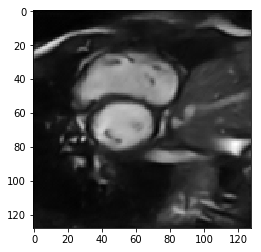

saving epoch {91}
Epoch: 92, Iteration: 1, Loss: 0.0007169392192736268, time: 2019-08-04 21:39:06.143204
Epoch: 92, Iteration: 101, Loss: 0.059016225597588345, time: 2019-08-04 21:41:07.774219
Epoch: 92, Iteration: 201, Loss: 0.11830565592390485, time: 2019-08-04 21:43:08.871834
Epoch: 92, Iteration: 301, Loss: 0.1755217096360866, time: 2019-08-04 21:45:10.086221
Epoch: 92, Iteration: 401, Loss: 0.23530318883422296, time: 2019-08-04 21:47:10.639199
Epoch: 92, Iteration: 501, Loss: 0.288506895856699, time: 2019-08-04 21:49:11.420550
Epoch: 92, Iteration: 601, Loss: 0.34596893785055727, time: 2019-08-04 21:51:13.557097
Epoch: 92, Iteration: 701, Loss: 0.40307573752943426, time: 2019-08-04 21:53:15.231466
Epoch: 92, Iteration: 801, Loss: 0.46064366718928795, time: 2019-08-04 21:55:16.990931
Epoch: 92, Iteration: 901, Loss: 0.5183482341963099, time: 2019-08-04 21:57:18.023154
Epoch: 92, Iteration: 1001, Loss: 0.5768304540833924, time: 2019-08-04 21:59:19.401694
Epoch: 92, Iteration: 1101, 

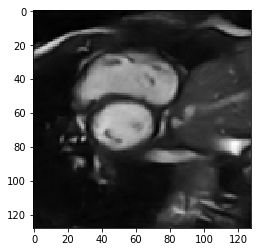

saving epoch {92}
Epoch: 93, Iteration: 1, Loss: 0.0005432310281321406, time: 2019-08-04 22:03:23.424358
Epoch: 93, Iteration: 101, Loss: 0.05439204799768049, time: 2019-08-04 22:05:24.746345
Epoch: 93, Iteration: 201, Loss: 0.10686893609818071, time: 2019-08-04 22:07:24.258024
Epoch: 93, Iteration: 301, Loss: 0.1607300803734688, time: 2019-08-04 22:09:23.582298
Epoch: 93, Iteration: 401, Loss: 0.21660431515192613, time: 2019-08-04 22:11:21.809238
Epoch: 93, Iteration: 501, Loss: 0.27200388751225546, time: 2019-08-04 22:13:19.681440
Epoch: 93, Iteration: 601, Loss: 0.3268958055705298, time: 2019-08-04 22:15:17.608756
Epoch: 93, Iteration: 701, Loss: 0.3875545389309991, time: 2019-08-04 22:17:15.863768
Epoch: 93, Iteration: 801, Loss: 0.44649714906699955, time: 2019-08-04 22:19:14.302215
Epoch: 93, Iteration: 901, Loss: 0.5028490139375208, time: 2019-08-04 22:21:13.181608
Epoch: 93, Iteration: 1001, Loss: 0.5611060486844508, time: 2019-08-04 22:23:12.468563
Epoch: 93, Iteration: 1101, L

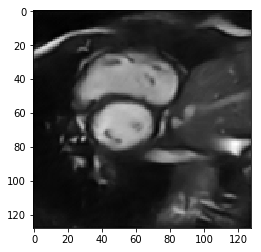

saving epoch {93}
Epoch: 94, Iteration: 1, Loss: 0.0004067127010785043, time: 2019-08-04 22:27:12.480914
Epoch: 94, Iteration: 101, Loss: 0.05236389345373027, time: 2019-08-04 22:29:11.254605
Epoch: 94, Iteration: 201, Loss: 0.10975955049798358, time: 2019-08-04 22:31:08.843809
Epoch: 94, Iteration: 301, Loss: 0.1672405669669388, time: 2019-08-04 22:33:06.511105
Epoch: 94, Iteration: 401, Loss: 0.22938504243211355, time: 2019-08-04 22:35:04.268893
Epoch: 94, Iteration: 501, Loss: 0.29229726882476825, time: 2019-08-04 22:37:01.705574
Epoch: 94, Iteration: 601, Loss: 0.34700013825204223, time: 2019-08-04 22:38:59.353956
Epoch: 94, Iteration: 701, Loss: 0.4036928978166543, time: 2019-08-04 22:40:56.973198
Epoch: 94, Iteration: 801, Loss: 0.45942305139033124, time: 2019-08-04 22:42:54.472709
Epoch: 94, Iteration: 901, Loss: 0.5177621902839746, time: 2019-08-04 22:44:52.045936
Epoch: 94, Iteration: 1001, Loss: 0.5740339187032077, time: 2019-08-04 22:46:49.647837
Epoch: 94, Iteration: 1101, 

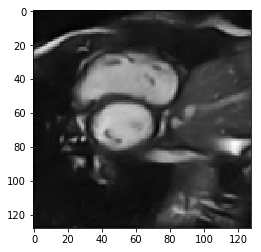

saving epoch {94}
Epoch: 95, Iteration: 1, Loss: 0.0006586576346307993, time: 2019-08-04 22:50:45.598174
Epoch: 95, Iteration: 101, Loss: 0.05240557625074871, time: 2019-08-04 22:52:43.151509
Epoch: 95, Iteration: 201, Loss: 0.10913235704356339, time: 2019-08-04 22:54:40.730870
Epoch: 95, Iteration: 301, Loss: 0.1632429974997649, time: 2019-08-04 22:56:38.344526
Epoch: 95, Iteration: 401, Loss: 0.2144649972615298, time: 2019-08-04 22:58:35.793937
Epoch: 95, Iteration: 501, Loss: 0.2766838788811583, time: 2019-08-04 23:00:33.339625
Epoch: 95, Iteration: 601, Loss: 0.33355350320925936, time: 2019-08-04 23:02:30.888091
Epoch: 95, Iteration: 701, Loss: 0.3926382661884418, time: 2019-08-04 23:04:28.528594
Epoch: 95, Iteration: 801, Loss: 0.44536154327215627, time: 2019-08-04 23:06:26.128076
Epoch: 95, Iteration: 901, Loss: 0.5001280602591578, time: 2019-08-04 23:08:23.594776
Epoch: 95, Iteration: 1001, Loss: 0.56104847502138, time: 2019-08-04 23:10:21.080947
Epoch: 95, Iteration: 1101, Loss

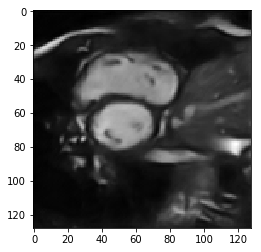

saving epoch {95}
Epoch: 96, Iteration: 1, Loss: 0.0006948471418581903, time: 2019-08-04 23:14:17.025007
Epoch: 96, Iteration: 101, Loss: 0.05828320667205844, time: 2019-08-04 23:16:14.593700
Epoch: 96, Iteration: 201, Loss: 0.11531589589139912, time: 2019-08-04 23:18:12.071379
Epoch: 96, Iteration: 301, Loss: 0.16675947267503943, time: 2019-08-04 23:20:09.643405
Epoch: 96, Iteration: 401, Loss: 0.22236741631058976, time: 2019-08-04 23:22:07.122324
Epoch: 96, Iteration: 501, Loss: 0.2786507351556793, time: 2019-08-04 23:24:04.681605
Epoch: 96, Iteration: 601, Loss: 0.3307671740913065, time: 2019-08-04 23:26:02.280029
Epoch: 96, Iteration: 701, Loss: 0.3917366333043901, time: 2019-08-04 23:27:59.736296
Epoch: 96, Iteration: 801, Loss: 0.45583320812147576, time: 2019-08-04 23:29:57.349229
Epoch: 96, Iteration: 901, Loss: 0.5062673796055606, time: 2019-08-04 23:31:54.791199
Epoch: 96, Iteration: 1001, Loss: 0.5625948753731791, time: 2019-08-04 23:33:52.296466
Epoch: 96, Iteration: 1101, L

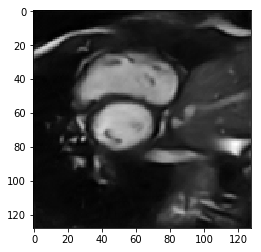

saving epoch {96}
Epoch: 97, Iteration: 1, Loss: 0.0004101341182831675, time: 2019-08-04 23:37:48.103095
Epoch: 97, Iteration: 101, Loss: 0.05250926715962123, time: 2019-08-04 23:39:45.657153
Epoch: 97, Iteration: 201, Loss: 0.10839423284051009, time: 2019-08-04 23:41:43.207041
Epoch: 97, Iteration: 301, Loss: 0.1637518771167379, time: 2019-08-04 23:43:40.854960
Epoch: 97, Iteration: 401, Loss: 0.22048209060449153, time: 2019-08-04 23:45:38.254761
Epoch: 97, Iteration: 501, Loss: 0.2752955334581202, time: 2019-08-04 23:47:35.779991
Epoch: 97, Iteration: 601, Loss: 0.3263178006163798, time: 2019-08-04 23:49:33.123818
Epoch: 97, Iteration: 701, Loss: 0.38338281330652535, time: 2019-08-04 23:51:30.535251
Epoch: 97, Iteration: 801, Loss: 0.4428215153457131, time: 2019-08-04 23:53:28.033860
Epoch: 97, Iteration: 901, Loss: 0.4971475336351432, time: 2019-08-04 23:55:25.482920
Epoch: 97, Iteration: 1001, Loss: 0.5582469766377471, time: 2019-08-04 23:57:22.926703
Epoch: 97, Iteration: 1101, Lo

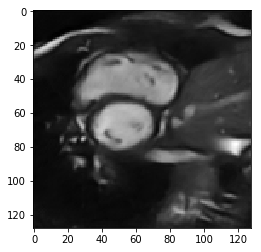

saving epoch {97}
Epoch: 98, Iteration: 1, Loss: 0.0005145334871485829, time: 2019-08-05 00:01:18.688873
Epoch: 98, Iteration: 101, Loss: 0.052137209015199915, time: 2019-08-05 00:03:16.164644
Epoch: 98, Iteration: 201, Loss: 0.10513804815127514, time: 2019-08-05 00:05:14.869751
Epoch: 98, Iteration: 301, Loss: 0.16281548497499898, time: 2019-08-05 00:07:16.068391
Epoch: 98, Iteration: 401, Loss: 0.22218387147586327, time: 2019-08-05 00:09:17.255298
Epoch: 98, Iteration: 501, Loss: 0.2752271154895425, time: 2019-08-05 00:11:18.915011
Epoch: 98, Iteration: 601, Loss: 0.3308817417710088, time: 2019-08-05 00:13:22.340028
Epoch: 98, Iteration: 701, Loss: 0.3835116066475166, time: 2019-08-05 00:15:24.279775
Epoch: 98, Iteration: 801, Loss: 0.44566705079341773, time: 2019-08-05 00:17:25.726583
Epoch: 98, Iteration: 901, Loss: 0.505294776710798, time: 2019-08-05 00:19:26.688674
Epoch: 98, Iteration: 1001, Loss: 0.561128078319598, time: 2019-08-05 00:21:28.049614
Epoch: 98, Iteration: 1101, Lo

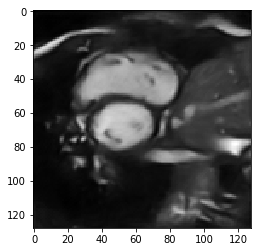

saving epoch {98}
Epoch: 99, Iteration: 1, Loss: 0.0007959298673085868, time: 2019-08-05 00:25:33.104574
Epoch: 99, Iteration: 101, Loss: 0.0566197779844515, time: 2019-08-05 00:27:35.005954
Epoch: 99, Iteration: 201, Loss: 0.10980986389040481, time: 2019-08-05 00:29:37.071641
Epoch: 99, Iteration: 301, Loss: 0.16694354322680738, time: 2019-08-05 00:31:37.346427
Epoch: 99, Iteration: 401, Loss: 0.22432733583264053, time: 2019-08-05 00:33:36.720009
Epoch: 99, Iteration: 501, Loss: 0.2803169280959992, time: 2019-08-05 00:35:35.900197
Epoch: 99, Iteration: 601, Loss: 0.3452347759885015, time: 2019-08-05 00:37:36.529742
Epoch: 99, Iteration: 701, Loss: 0.3970102594612399, time: 2019-08-05 00:39:37.971859
Epoch: 99, Iteration: 801, Loss: 0.45009178381587844, time: 2019-08-05 00:41:40.259693
Epoch: 99, Iteration: 901, Loss: 0.5053341679886216, time: 2019-08-05 00:43:42.597132
Epoch: 99, Iteration: 1001, Loss: 0.5653375187393976, time: 2019-08-05 00:45:44.873833
Epoch: 99, Iteration: 1101, Lo

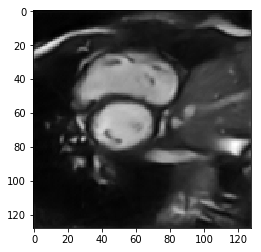

saving epoch {99}
Epoch: 100, Iteration: 1, Loss: 0.000448468083050102, time: 2019-08-05 00:49:47.746075
Epoch: 100, Iteration: 101, Loss: 0.05263981252210215, time: 2019-08-05 00:51:48.580550
Epoch: 100, Iteration: 201, Loss: 0.10636630888620857, time: 2019-08-05 00:53:48.576771
Epoch: 100, Iteration: 301, Loss: 0.16160084585135337, time: 2019-08-05 00:55:50.246145
Epoch: 100, Iteration: 401, Loss: 0.21619641428696923, time: 2019-08-05 00:57:51.270978
Epoch: 100, Iteration: 501, Loss: 0.2711683189845644, time: 2019-08-05 00:59:51.144851
Epoch: 100, Iteration: 601, Loss: 0.3265037347446196, time: 2019-08-05 01:01:50.328894
Epoch: 100, Iteration: 701, Loss: 0.38387506987783127, time: 2019-08-05 01:03:49.446997
Epoch: 100, Iteration: 801, Loss: 0.43885530455736443, time: 2019-08-05 01:05:49.514908
Epoch: 100, Iteration: 901, Loss: 0.49653608322842047, time: 2019-08-05 01:07:48.050203
Epoch: 100, Iteration: 1001, Loss: 0.5534298268612474, time: 2019-08-05 01:09:46.238030
Epoch: 100, Itera

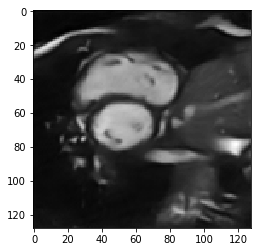

saving epoch {100}


In [48]:
training_loop(100, optimizer, model, loss_fn, train_loader)

# Saving the results of reconstruction for quantitative assessment later

In [49]:
print(test_recon.shape)
print(test_truth.shape)
print(test_mask.shape)
print(k_test.shape)

torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])


In [50]:
result_vec = []

In [51]:
for k in range(222):
    a = test_recon[k:k+1,:,:,:,:]
    a = a.float()
    b = test_mask[k:k+1,:,:,:,:]
    b = b.float()
    c = k_test[k:k+1,:,:,:,:]
    c = c.float()
    result = model(a.to(device), b.to(device), c.to(device), mode=True)
    result = result.to('cpu')
    result = result.detach()
    result = result.numpy()
    result_vec.append(result)

In [52]:
len(result_vec)

222

In [53]:
res_save = np.ndarray((128,128,200,222))

In [54]:
a = torch.FloatTensor(result_vec)

In [55]:
a.shape

torch.Size([222, 1, 2, 128, 128, 20])

In [56]:
a = a.permute(0,3,4,5,1,2)

In [57]:
b = a[:,:,:,:,0,0]

In [58]:
b.shape

torch.Size([222, 128, 128, 20])

In [59]:
b = b.numpy()

In [60]:
import scipy.io

In [61]:
scipy.io.savemat('Results_DCRNN_20und_100epoch.mat', {'recon':b})

In [63]:
test_truth.shape

torch.Size([222, 2, 128, 128, 20])